In [1]:
import numpy as np
import pandas as pd
from scipy import optimize
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# 1. Preprocess the Data

This part we give the formula and the head 5 lines of the data

In [2]:
def mapping(sigma, mu, value):
    normalized_value = (value - mu)/sigma
    if(normalized_value > 3*sigma): 
        invest = 1
    elif (normalized_value > 1.67*sigma):
        invest = 0.75
    elif (normalized_value > 0*sigma):
        invest = 0.5
    elif (normalized_value > -1.67*sigma):
        invest = 0.25
    else:
        invest = 0

In [3]:
# Read FEDs data 
dat = pd.read_csv('feds.csv')
dat.Date = pd.to_datetime(dat.Date)

In [4]:
# Read .dat file of Fama Bliss Zero Coupon Bond prices used on the original paper
with open('bondprice.dat','r') as f:
    next(f) # skip first row
    next(f)
    next(f)
    next(f)
    df = pd.DataFrame(l.rstrip().split() for l in f)
df.columns = ['Date', 'Year 1', 'Year 2', 'Year 3', 'Year 4', 'Year 5']
df.Date = pd.to_datetime(df.Date)
fb_dat = df

In [5]:
# Create new columns with month and year from each date
dat['year'] =  pd.DatetimeIndex(dat.Date).year
dat['month'] =  pd.DatetimeIndex(dat.Date).month

fb_dat['year'] = pd.DatetimeIndex(fb_dat.Date).year
fb_dat['month'] = pd.DatetimeIndex(fb_dat.Date).month

In [6]:
# Get only the values correspoding to the first trading day of each month
dat_month = dat.groupby(['year','month']).first().reset_index()
year = dat_month.pop('year')
month = dat_month.pop('month')

dat_month = dat_month.set_index('Date')
dat_month = dat_month[1:]

fb_dat_month = fb_dat.groupby(['year','month']).first().reset_index()
fb_dat_month.pop('year')
fb_dat_month.pop('month')
fb_dat_month = fb_dat_month.set_index('Date')
fb_dat_month = fb_dat_month[1:]
fb_dat_month = fb_dat_month.astype(float)
dat_month.head()

SVENY01  SVENY02  SVENY03  SVENY04  SVENY05  SVENY06  SVENY07  \
Date                                                                        
1961-07-31   2.7780   3.2304   3.5068   3.6787   3.7907   3.8678   3.9234   
1961-08-31   2.9863   3.3990   3.6481   3.7919   3.8812   3.9412   3.9841   
1961-09-29   2.9358   3.3250   3.5412   3.6661   3.7442   3.7968   3.8345   
1961-10-31   2.8936   3.2396   3.4616   3.6087   3.7096   3.7813   3.8339   
1961-11-30   3.0000   3.3013   3.5216   3.6775   3.7825   3.8477   3.8817   

            SVENY08  SVENY09  SVENY10  
Date                                   
1961-07-31      NaN      NaN      NaN  
1961-08-31      NaN      NaN      NaN  
1961-09-29      NaN      NaN      NaN  
1961-10-31      NaN      NaN      NaN  
1961-11-30      NaN      NaN      NaN

In [7]:
# Add columns of all ones at the begining of the data frame and change bond prices to a face value of 1
bond_price = dat_month / 100

bond_price['spot'] = np.ones(len(bond_price)) 
cols = bond_price.columns.tolist()
bond_price = bond_price[[cols[-1]] + cols[:-1]] 

fb_bond_price = fb_dat_month/100
fb_bond_price['spot'] = np.ones(len(fb_bond_price))
fb_cols = fb_bond_price.columns.tolist()
fb_bond_price = fb_bond_price[[cols[-1]] + fb_cols[:-1]]

bond_price.head()


spot   SVENY01   SVENY02   SVENY03   SVENY04   SVENY05   SVENY06  \
Date                                                                           
1961-07-31   1.0  0.027780  0.032304  0.035068  0.036787  0.037907  0.038678   
1961-08-31   1.0  0.029863  0.033990  0.036481  0.037919  0.038812  0.039412   
1961-09-29   1.0  0.029358  0.033250  0.035412  0.036661  0.037442  0.037968   
1961-10-31   1.0  0.028936  0.032396  0.034616  0.036087  0.037096  0.037813   
1961-11-30   1.0  0.030000  0.033013  0.035216  0.036775  0.037825  0.038477   

             SVENY07  SVENY08  SVENY09  SVENY10  
Date                                             
1961-07-31  0.039234      NaN      NaN      NaN  
1961-08-31  0.039841      NaN      NaN      NaN  
1961-09-29  0.038345      NaN      NaN      NaN  
1961-10-31  0.038339      NaN      NaN      NaN  
1961-11-30  0.038817      NaN      NaN      NaN

In [8]:
for i in range(11):
    bond_price.iloc[:, i] = np.exp(-bond_price.iloc[:, i] * i)
bond_price.head()

spot   SVENY01   SVENY02   SVENY03   SVENY04   SVENY05   SVENY06  \
Date                                                                           
1961-07-31   1.0  0.972602  0.937435  0.900141  0.863166  0.827344  0.792892   
1961-08-31   1.0  0.970578  0.934279  0.896333  0.859267  0.823608  0.789408   
1961-09-29   1.0  0.971069  0.935663  0.899212  0.863601  0.829270  0.796277   
1961-10-31   1.0  0.971479  0.937262  0.901362  0.865586  0.830705  0.797018   
1961-11-30   1.0  0.970446  0.936107  0.899741  0.863208  0.827683  0.793849   

             SVENY07  SVENY08  SVENY09  SVENY10  
Date                                             
1961-07-31  0.759847      NaN      NaN      NaN  
1961-08-31  0.756625      NaN      NaN      NaN  
1961-09-29  0.764590      NaN      NaN      NaN  
1961-10-31  0.764623      NaN      NaN      NaN  
1961-11-30  0.762068      NaN      NaN      NaN

$$p_t^{(n)} = ln(bondPrice)$$

In [9]:
p = np.log(bond_price)
fb_p = np.log(fb_bond_price)
p.head()

spot   SVENY01   SVENY02   SVENY03   SVENY04   SVENY05   SVENY06  \
Date                                                                           
1961-07-31   0.0 -0.027780 -0.064608 -0.105204 -0.147148 -0.189535 -0.232068   
1961-08-31   0.0 -0.029863 -0.067980 -0.109443 -0.151676 -0.194060 -0.236472   
1961-09-29   0.0 -0.029358 -0.066500 -0.106236 -0.146644 -0.187210 -0.227808   
1961-10-31   0.0 -0.028936 -0.064792 -0.103848 -0.144348 -0.185480 -0.226878   
1961-11-30   0.0 -0.030000 -0.066026 -0.105648 -0.147100 -0.189125 -0.230862   

             SVENY07  SVENY08  SVENY09  SVENY10  
Date                                             
1961-07-31 -0.274638      NaN      NaN      NaN  
1961-08-31 -0.278887      NaN      NaN      NaN  
1961-09-29 -0.268415      NaN      NaN      NaN  
1961-10-31 -0.268373      NaN      NaN      NaN  
1961-11-30 -0.271719      NaN      NaN      NaN

$$ y_t{(n)} = -\frac1n p_t^{(n)}$$

In [10]:
y = p.copy()
for i in range(1,11):
    y.iloc[:,i] = -1.0/(i) * y.iloc[:,i]
y.spot = np.ones(len(y))

fb_y = fb_p.copy()
for i in range(1,6):
    fb_y.iloc[:,i] = -1.0/(i) * fb_y.iloc[:,i]
fb_y.spot = np.ones(len(fb_y))
fb_y.head()

spot    Year 1    Year 2    Year 3    Year 4    Year 5
Date                                                              
1952-07-31   1.0  0.019234  0.020250  0.020870  0.020007  0.021401
1952-08-29   1.0  0.019611  0.020541  0.021399  0.020449  0.022025
1952-09-30   1.0  0.019886  0.020880  0.021495  0.020585  0.022930
1952-10-31   1.0  0.019071  0.020546  0.021484  0.021038  0.021684
1952-11-28   1.0  0.020662  0.021757  0.021904  0.021177  0.021867

$$f_t^{(n)} = p_t^{(n-1)} - p_t^{(n)}$$

In [11]:
f = p.copy()
f = -f.diff(axis = 1)
f.spot = np.ones(len(f))

fb_f = fb_p.copy()
fb_f = -fb_f.diff(axis = 1)
fb_f.spot = np.ones(len(fb_f))
f.head()

spot   SVENY01   SVENY02   SVENY03   SVENY04   SVENY05   SVENY06  \
Date                                                                           
1961-07-31   1.0  0.027780  0.036828  0.040596  0.041944  0.042387  0.042533   
1961-08-31   1.0  0.029863  0.038117  0.041463  0.042233  0.042384  0.042412   
1961-09-29   1.0  0.029358  0.037142  0.039736  0.040408  0.040566  0.040598   
1961-10-31   1.0  0.028936  0.035856  0.039056  0.040500  0.041132  0.041398   
1961-11-30   1.0  0.030000  0.036026  0.039622  0.041452  0.042025  0.041737   

             SVENY07  SVENY08  SVENY09  SVENY10  
Date                                             
1961-07-31  0.042570      NaN      NaN      NaN  
1961-08-31  0.042415      NaN      NaN      NaN  
1961-09-29  0.040607      NaN      NaN      NaN  
1961-10-31  0.041495      NaN      NaN      NaN  
1961-11-30  0.040857      NaN      NaN      NaN

$$r_{t+1}^{(n)} = p_{t+1}^{(n-1)} - _t^{(n)}$$

In [12]:
p1 = p.copy()
p1 = p1.shift(-12) # t+1
p1 = p1.shift(1, axis=1) # n-1
r = p1 - p

fb_p1 = fb_p.copy()
fb_p1 = fb_p1.shift(-12)
fb_p1 = fb_p1.shift(1, axis = 1)
fb_r = fb_p1 - fb_p
r.head()

spot   SVENY01   SVENY02   SVENY03   SVENY04   SVENY05   SVENY06  \
Date                                                                           
1961-07-31   NaN  0.027780  0.033298  0.037274  0.039802  0.041295  0.042158   
1961-08-31   NaN  0.029863  0.038200  0.046633  0.051503  0.053608  0.054127   
1961-09-29   NaN  0.029358  0.037903  0.044746  0.047620  0.047694  0.046203   
1961-10-31   NaN  0.028936  0.036415  0.041852  0.044868  0.046000  0.045863   
1961-11-30   NaN  0.030000  0.036376  0.042592  0.047194  0.049909  0.050757   

             SVENY07  SVENY08  SVENY09  SVENY10  
Date                                             
1961-07-31  0.042654      NaN      NaN      NaN  
1961-08-31  0.053821      NaN      NaN      NaN  
1961-09-29  0.043919      NaN      NaN      NaN  
1961-10-31  0.044927      NaN      NaN      NaN  
1961-11-30  0.049767      NaN      NaN      NaN

$$ rx_{t+1}^{(n)} = r_{t+1}^{(n)} - y_t^{(1)}$$

In [13]:
y1 = y.copy()
for i in range(2,11):
    y1.iloc[:,i] = y1.iloc[:,1]
rx = r - y1

fb_y1 = fb_y.copy()
for i in range(2,6):
    fb_y1.iloc[:,i] = fb_y1.iloc[:,1]
fb_rx = fb_r - fb_y1

rx.head()

spot  SVENY01   SVENY02   SVENY03   SVENY04   SVENY05   SVENY06  \
Date                                                                          
1961-07-31   NaN      0.0  0.005518  0.009494  0.012022  0.013515  0.014378   
1961-08-31   NaN      0.0  0.008337  0.016770  0.021640  0.023745  0.024264   
1961-09-29   NaN      0.0  0.008545  0.015388  0.018262  0.018336  0.016845   
1961-10-31   NaN      0.0  0.007479  0.012916  0.015932  0.017064  0.016927   
1961-11-30   NaN      0.0  0.006376  0.012592  0.017194  0.019909  0.020757   

             SVENY07  SVENY08  SVENY09  SVENY10  
Date                                             
1961-07-31  0.014874      NaN      NaN      NaN  
1961-08-31  0.023958      NaN      NaN      NaN  
1961-09-29  0.014561      NaN      NaN      NaN  
1961-10-31  0.015991      NaN      NaN      NaN  
1961-11-30  0.019767      NaN      NaN      NaN

# 2. The Regression

In [14]:
# Set train and test data
idx_5 = (y.index < pd.to_datetime('2017-9-1')) & (y.index > pd.to_datetime('1964-1-1'))
idx_10 = (y.index < pd.to_datetime('2017-9-1')) & (y.index > pd.to_datetime('1972-1-1'))
idx_train5 = (y.index < pd.to_datetime('2008-1-1')) & (y.index > pd.to_datetime('1964-1-1'))
idx_test5 = (y.index < pd.to_datetime('2017-9-1')) & (y.index > pd.to_datetime('2008-1-1'))
idx_train10 = (y.index < pd.to_datetime('2008-1-1')) & (y.index > pd.to_datetime('1972-1-1'))
idx_test10 = (y.index < pd.to_datetime('2017-9-1')) & (y.index > pd.to_datetime('2008-1-1'))

# Select 5 year data
yt5 = y[idx_5].iloc[:,1:6]
ft5 = f[idx_5].iloc[:,1:6]
rxt5 = rx[idx_5].iloc[:,2:6]
rxt_bar5 = rxt5.mean(axis = 1)

# Select 10 year data
yt10 = y[idx_10].iloc[:,1:11]
ft10 = f[idx_10].iloc[:,1:11]
rxt10 = rx[idx_10].iloc[:,2:11]
rxt_bar10 = rxt10.mean(axis = 1)


# Select 5 year train data
yt_train5 = y[idx_train5].iloc[:,1:6]
ft_train5 = f[idx_train5].iloc[:,1:6]
rxt_train5 = rx[idx_train5].iloc[:,2:6]
rxt_bar_train5 = rxt_train5.mean(axis = 1)

# Select 5 year test data
yt_test5 = y[idx_test5].iloc[:,1:6]
ft_test5 = f[idx_test5].iloc[:,1:6]
rxt_test5 = rx[idx_test5].iloc[:,2:6]
rxt_bar_test5 = rxt_test5.mean(axis = 1)

# Select 10 year train data
yt_train10 = y[idx_train10].iloc[:,1:11]
ft_train10 = f[idx_train10].iloc[:,1:11]
rxt_train10 = rx[idx_train10].iloc[:,2:11]
rxt_bar_train10 = rxt_train10.mean(axis = 1)

# Select 10 year test data
yt_test10 = y[idx_test10].iloc[:,1:11]
ft_test10 = f[idx_test10].iloc[:,1:11]
rxt_test10 = rx[idx_test10].iloc[:,2:11]
rxt_bar_test10 = rxt_test10.mean(axis = 1)

# Comparison Excess Returns FEDs VS Fama Bliss 

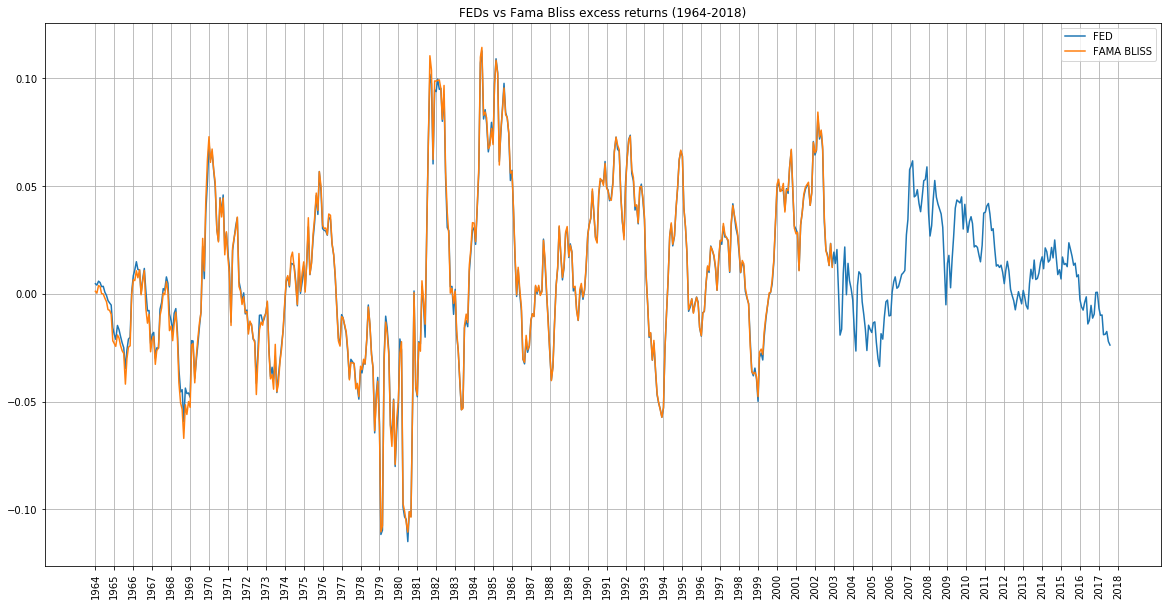

In [16]:
# Compute average Excess returns from maturities 1-5 years
rxt_fed = rx.iloc[:,2:6].mean(axis = 1)
rxt_fb = fb_rx.iloc[:,2:6].mean(axis = 1)

plt.figure(figsize=(20,10))
plt.plot(rxt_fed[(y.index < pd.to_datetime('2017-9-1')) & (y.index > pd.to_datetime('1964-1-1'))], label='FED')
plt.plot(rxt_fb[(fb_y.index < pd.to_datetime('2003-12-1')) & (fb_y.index > pd.to_datetime('1964-1-1'))], label='FAMA BLISS')
plt.xticks(rxt_fed[(y.index < pd.to_datetime('2018-2-1')) & (y.index > pd.to_datetime('1964-1-1'))].index[::12],
           rotation = 90)
plt.grid()
plt.legend()
plt.title('FEDs vs Fama Bliss excess returns (1964-2018)')
plt.show();

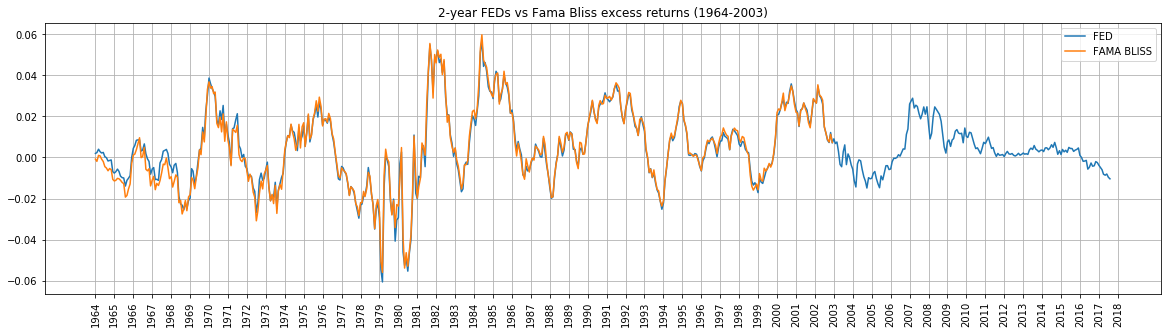

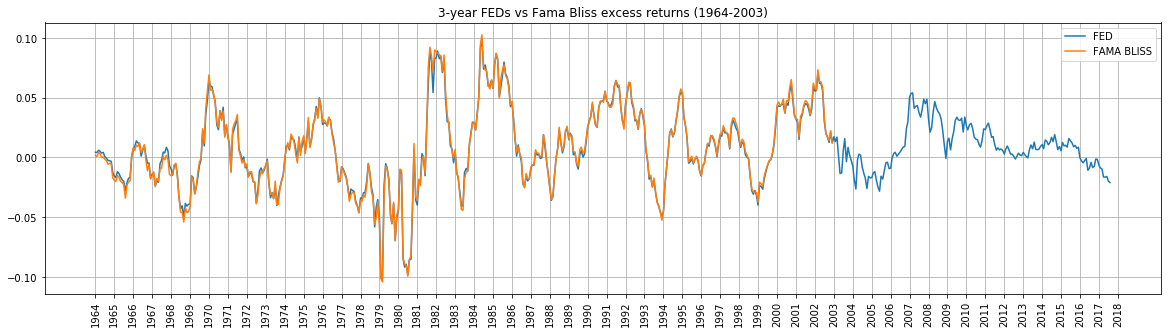

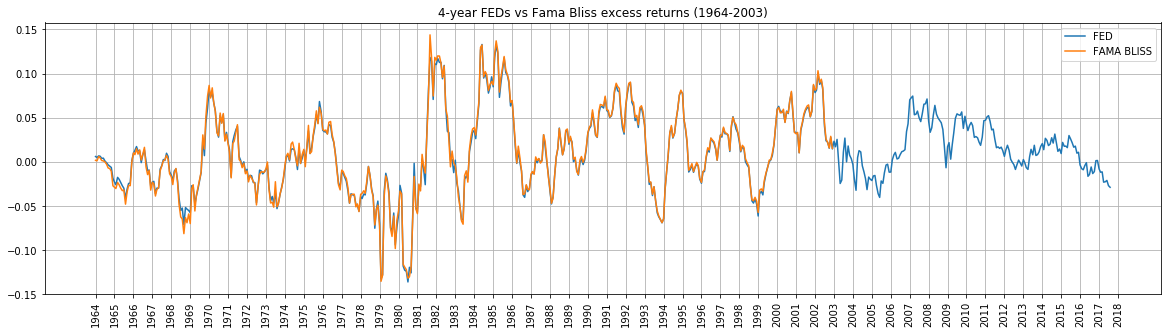

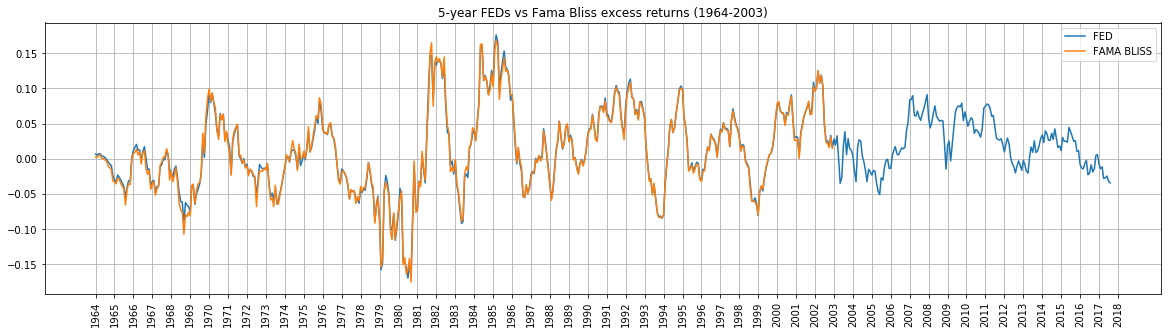

In [17]:
# Plot excess returns 2 to 5 year maturity in subplots

plt.figure(figsize=(20,5))
plt.plot(rx.iloc[(y.index < pd.to_datetime('2017-9-1')) & (y.index > pd.to_datetime('1964-1-1')),2], label='FED')
plt.plot(fb_rx.iloc[(fb_y.index < pd.to_datetime('2003-12-1')) & (fb_y.index > pd.to_datetime('1964-1-1')),2], label='FAMA BLISS')
plt.xticks(rx[(y.index < pd.to_datetime('2018-2-1')) & (y.index > pd.to_datetime('1964-1-1'))].index[::12],
           rotation = 90)
plt.grid()
plt.legend()
plt.title('2-year FEDs vs Fama Bliss excess returns (1964-2003)')
plt.show();

plt.figure(figsize=(20,5))
plt.plot(rx.iloc[(y.index < pd.to_datetime('2017-9-1')) & (y.index > pd.to_datetime('1964-1-1')),3], label='FED')
plt.plot(fb_rx.iloc[(fb_y.index < pd.to_datetime('2003-12-1')) & (fb_y.index > pd.to_datetime('1964-1-1')),3], label='FAMA BLISS')
plt.xticks(rx[(y.index < pd.to_datetime('2018-2-1')) & (y.index > pd.to_datetime('1964-1-1'))].index[::12],
           rotation = 90)
plt.grid()
plt.legend()
plt.title('3-year FEDs vs Fama Bliss excess returns (1964-2003)')
plt.show();

plt.figure(figsize=(20,5))
plt.plot(rx.iloc[(y.index < pd.to_datetime('2017-9-1')) & (y.index > pd.to_datetime('1964-1-1')),4], label='FED')
plt.plot(fb_rx.iloc[(fb_y.index < pd.to_datetime('2003-12-1')) & (fb_y.index > pd.to_datetime('1964-1-1')),4], label='FAMA BLISS')
plt.xticks(rx[(y.index < pd.to_datetime('2018-2-1')) & (y.index > pd.to_datetime('1964-1-1'))].index[::12],
           rotation = 90)
plt.grid()
plt.legend()
plt.title('4-year FEDs vs Fama Bliss excess returns (1964-2003)')
plt.show();

plt.figure(figsize=(20,5))
plt.plot(rx.iloc[(y.index < pd.to_datetime('2017-9-1')) & (y.index > pd.to_datetime('1964-1-1')),5], label='FED')
plt.plot(fb_rx.iloc[(fb_y.index < pd.to_datetime('2003-12-1')) & (fb_y.index > pd.to_datetime('1964-1-1')),5], label='FAMA BLISS')
plt.xticks(rx[(y.index < pd.to_datetime('2018-2-1')) & (y.index > pd.to_datetime('1964-1-1'))].index[::12],
           rotation = 90)
plt.grid()
plt.legend()
plt.title('5-year FEDs vs Fama Bliss excess returns (1964-2003)')
plt.show();

# Single factor model regression

In [18]:
# Function to run the regressions
def simple_model_regressions (start_train, end_train, start_test, end_test, 
                              returns_data, forwards_data, excess_ret_data, maturity):
    
    # Determine Date periods
    idx = ((returns_data.index >= pd.to_datetime(start_train)) &
           (returns_data.index <= pd.to_datetime(end_test)))
    idx_train = ((returns_data.index >= pd.to_datetime(start_train)) & 
                  (returns_data.index <= pd.to_datetime(end_train)))
    idx_test = ((returns_data.index >= pd.to_datetime(start_test)) &
                 (returns_data.index <= pd.to_datetime(end_test)))

    # Select appropiate data and divide it into train set and test set
    yt = returns_data[idx].iloc[:,1:(maturity+1)]
    ft = forwards_data[idx].iloc[:,1:(maturity+1)]
    rxt = excess_ret_data[idx].iloc[:,2:(maturity+1)]
    rxt_bar = rxt.mean(axis = 1)

    # Select 5 year train data
    yt_train = returns_data[idx_train].iloc[:,1:(maturity+1)]
    ft_train = forwards_data[idx_train].iloc[:,1:(maturity+1)]
    rxt_train = excess_ret_data[idx_train].iloc[:,2:(maturity+1)]
    rxt_bar_train = rxt_train.mean(axis = 1)

    # Select 5 year test data
    yt_test = returns_data[idx_test].iloc[:,1:(maturity+1)]
    ft_test = forwards_data[idx_test].iloc[:,1:(maturity+1)]
    rxt_test = excess_ret_data[idx_test].iloc[:,2:(maturity+1)]
    rxt_bar_test = rxt_test.mean(axis = 1)
    # First Regression
    model = LinearRegression()
    R_sq = np.zeros((maturity-1))

    model.fit(ft_train,rxt_bar_train)
    gamma = model.coef_
    R_sq = model.score(ft_train,rxt_bar_train)

    # Second Regression
    aux = pd.DataFrame(np.sum((ft_train).mul(gamma), axis = 1) + model.intercept_)

    aux_test = pd.DataFrame(np.sum((ft_test).mul(gamma), axis = 1) + model.intercept_)

    models = []
    b = np.zeros((maturity-1))
    reg_coefs = np.zeros([maturity,maturity-1])
    R_sq = np.zeros((maturity-1))
    rxt_predict = rxt_test.copy()

    for i in range((maturity-1)):
        model_b = LinearRegression()
        model_b.fit(aux,rxt_train.iloc[:,i])
        b[i] = model_b.coef_[0]
        reg_coefs[:,i] = b[i]*gamma
        rxt_predict.iloc[:,i] = model_b.predict(aux_test)
        R_sq[i] = model_b.score(aux_test,rxt_test.iloc[:,i])
        models.append(model_b)
    rxt_predict_bar = np.mean(rxt_predict, axis = 1)

    return gamma, b, reg_coefs, rxt_predict, rxt_predict_bar, rxt_bar, 

## FAMA BLISS: Train set (1964 - 2003), Test set (1964 - 2003). Up to 5-year maturities

In [19]:
fb_yt5 = fb_y[(fb_y.index < pd.to_datetime('2003-1-1')) & (fb_y.index > pd.to_datetime('1964-1-1'))].iloc[:,1:6]
fb_ft5 = fb_f[(fb_y.index < pd.to_datetime('2003-1-1')) & (fb_y.index > pd.to_datetime('1964-1-1'))].iloc[:,1:6]
fb_rxt5 = fb_rx[(fb_y.index < pd.to_datetime('2003-1-1')) & (fb_y.index > pd.to_datetime('1964-1-1'))].iloc[:,2:6]
fb_rxt_bar5 = fb_rxt5.mean(axis = 1)

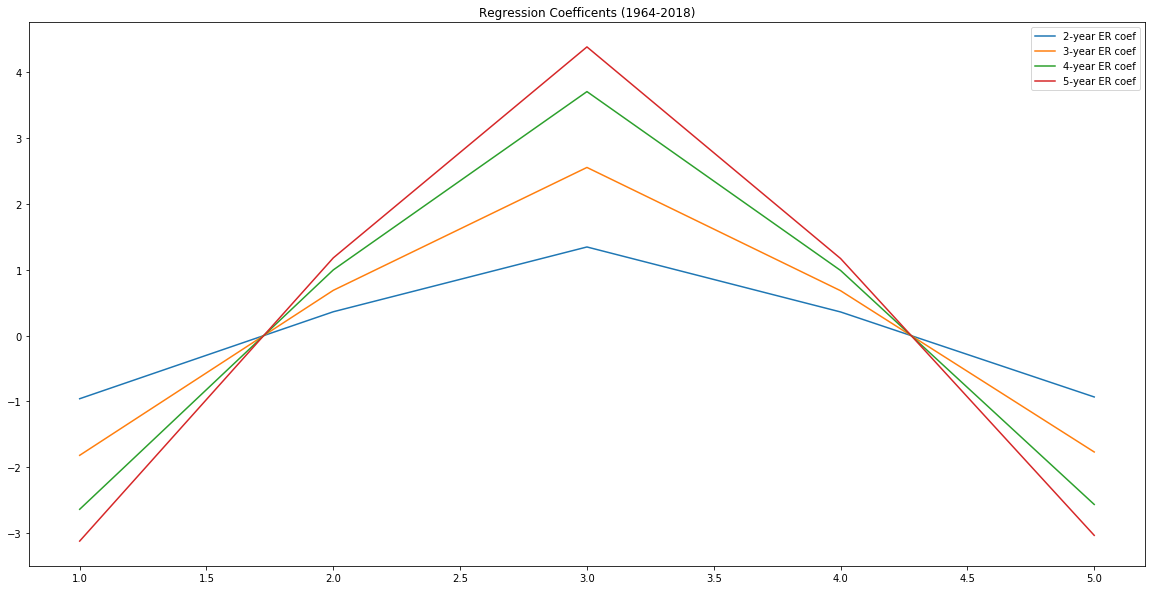

In [21]:
fb_model = LinearRegression()
fb_R_sq_model = np.zeros(4)

fb_model.fit(fb_ft5,fb_rxt_bar5)
fb_gamma = fb_model.coef_
fb_R_sq_model = fb_model.score(fb_ft5,fb_rxt_bar5)

fb_aux = pd.DataFrame(np.sum((fb_ft5).mul(fb_gamma), axis = 1) + fb_model.intercept_)
fb_aux.insert(0, 'ones', np.ones(len(fb_aux)))

fb_models = []
fb_b = np.zeros(4)
fb_R_sq = np.zeros(4)
fb_rxt_predict = fb_rxt5.copy()

for i in range(4):
    fb_model_b = LinearRegression(fit_intercept=False)
    fb_model_b.fit(fb_aux,fb_rxt5.iloc[:,i])
    fb_b[i] = fb_model_b.coef_[1]
    fb_rxt_predict.iloc[:,i] = fb_model_b.predict(fb_aux)
    fb_R_sq[i] = fb_model_b.score(fb_aux,fb_rxt5.iloc[:,i])
    fb_models.append(fb_model_b)
plt.figure(figsize=(20,10))
for i in range(4):
    plt.plot(range(1,6),fb_b[i]*fb_gamma, label = str(i+2) + '-year ER coef')
fb_rxt_predict_bar = np.mean(fb_rxt_predict, axis = 1)
plt.legend()
plt.title('Regression Coefficents (1964-2018)')
plt.show();

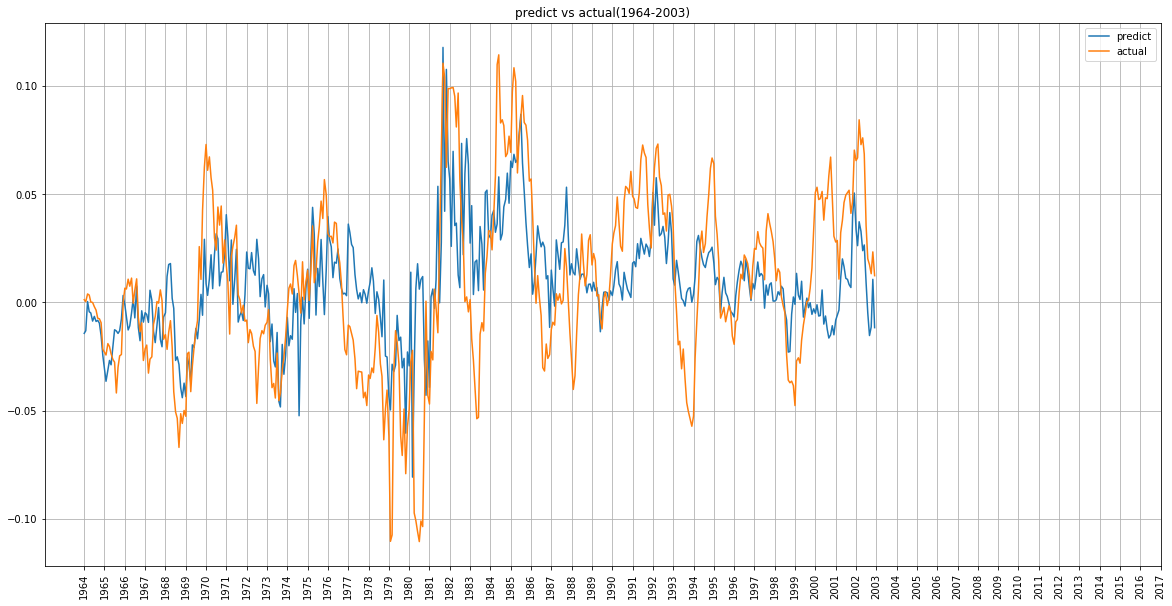

array([0.31361257, 0.33730054, 0.3700371 , 0.34471039])

In [22]:
plt.figure(figsize=(20,10))
plt.plot(fb_rxt_predict_bar, label='predict')
plt.plot(fb_rxt_bar5, label='actual')
plt.xticks(rxt_bar5.index[::12],rotation = 90)
plt.legend()
plt.grid(True)
plt.title('predict vs actual(1964-2003)')
plt.show();
fb_R_sq

## FEDs DATA: Train set (1964 - 2007), Test set (2008 - 2018). Up to 5-year maturities

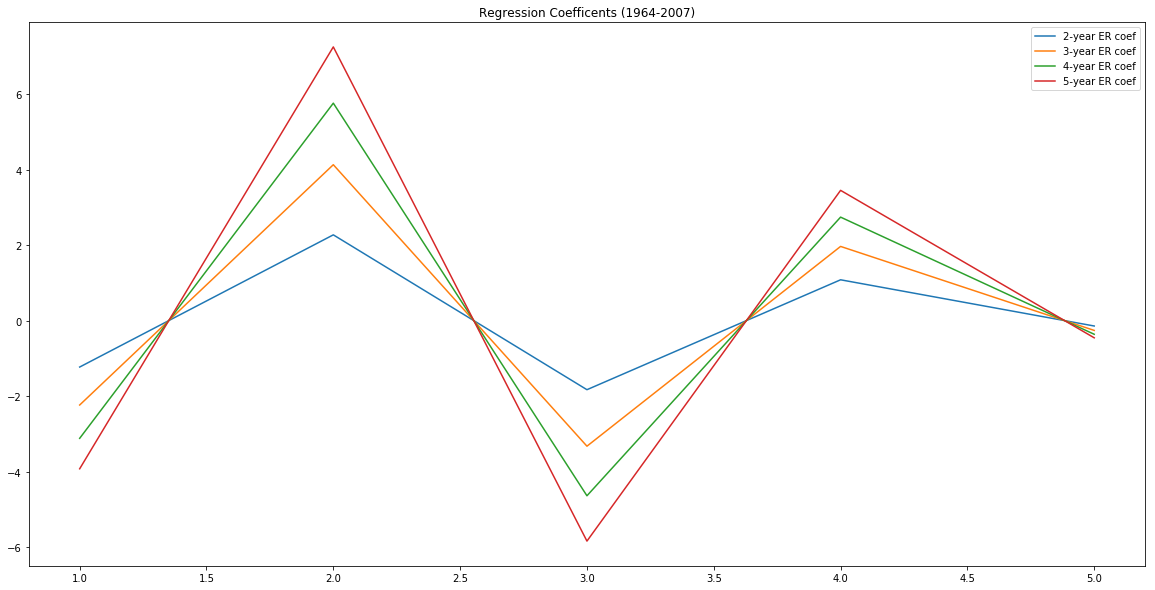

In [26]:
# First Regression
model = LinearRegression()
R_sq_model = np.zeros(4)

model.fit(ft_train5,rxt_bar_train5)
gamma = model.coef_
R_sq_model = model.score(ft_train5,rxt_bar_train5)

# Second Regression
aux = pd.DataFrame(np.sum((ft_train5).mul(gamma), axis = 1) + model.intercept_)

aux_test = pd.DataFrame(np.sum((ft_test5).mul(gamma), axis = 1) + model.intercept_)

models = []
b = np.zeros(4)
R_sq = np.zeros(4)
rxt_predict = rxt_test5.copy()

for i in range(4):
    model_b = LinearRegression(fit_intercept=False)
    model_b.fit(aux,rxt_train5.iloc[:,i])
    b[i] = model_b.coef_[0]
    rxt_predict.iloc[:,i] = model_b.predict(aux_test)
    R_sq[i] = model_b.score(aux_test,rxt_test5.iloc[:,i])
    models.append(model_b)
plt.figure(figsize=(20,10))
#pre = 0
for i in range(4):
    plt.plot(range(1,6),b[i]*gamma, label = str(i+2) + '-year ER coef')
#    pre = pre + ft_test5.mul(b[i]*gamma)
rxt_predict_bar = np.mean(rxt_predict, axis = 1)
plt.legend()
plt.title('Regression Coefficents (1964-2007)')
plt.show();

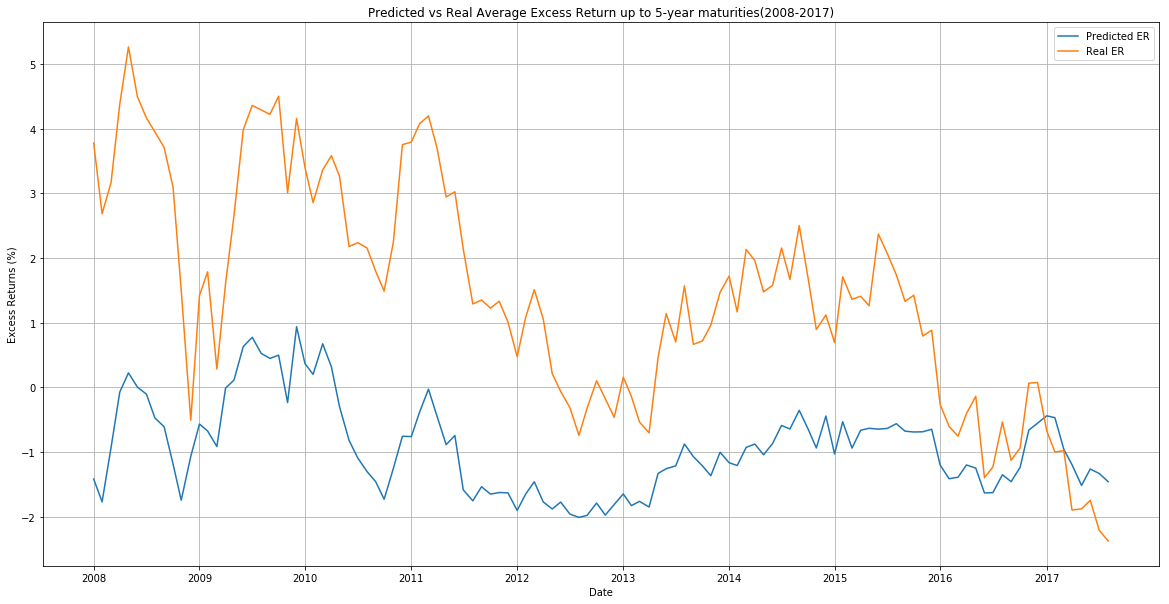

array([-1.44791491, -1.53660337, -1.42591115, -1.26932303])

In [28]:
plt.figure(figsize=(20,10))
plt.plot(rxt_predict_bar*100, label='Predicted ER')
plt.plot(rxt_bar_test5*100, label='Real ER')
#plt.plot(np.sum(pre*100, axis = 1)/4, label='x')
plt.xticks(rxt_bar_test5.index[::12])
plt.xlabel("Date")
plt.ylabel("Excess Returns (%)")
plt.legend()
plt.grid(True)
plt.title('Predicted vs Real Average Excess Return up to 5-year maturities(2008-2017)')
plt.show();
R_sq

### Analysis of Predicted VS Actual Excess Returns

In [298]:
# Correlation between actual and predicted average excess returns with train set 1964 - 2008 and test set 2008 - 2018
np.corrcoef(rxt_predict_bar, rxt_bar_test5)

array([[1.        , 0.67746323],
       [0.67746323, 1.        ]])

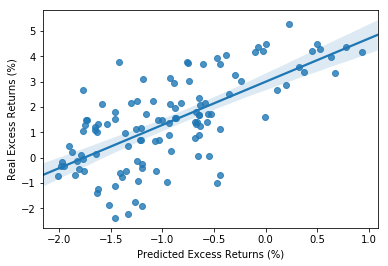

In [299]:
import seaborn as sns
ax = sns.regplot(x=rxt_predict_bar*100, y=rxt_bar_test5*100)
ax.set(xlabel = "Predicted Excess Returns (%)", ylabel = "Real Excess Returns (%)")
plt.show()

## FEDs DATA: Train set (1964 - 2007), Test set (2008 - 2018). Up to 10-year maturities

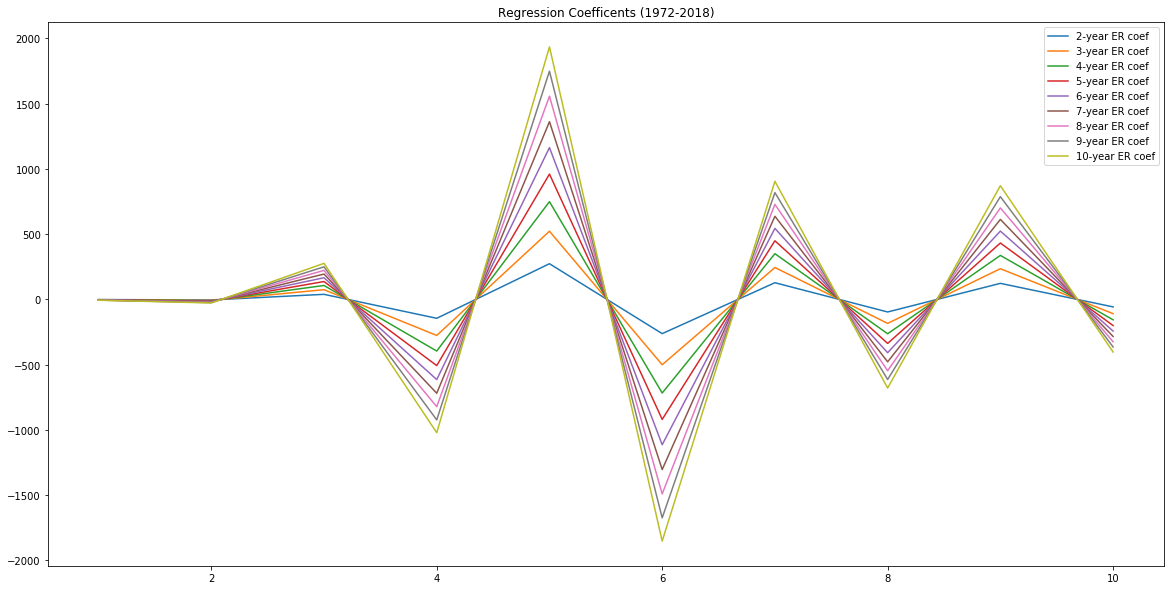

In [29]:
model = LinearRegression()
R_sq = np.zeros(9)

model.fit(ft_train10,rxt_bar_train10)
gamma = model.coef_
R_sq = model.score(ft_train10,rxt_bar_train10)

aux = pd.DataFrame(np.sum((ft_train10).mul(gamma), axis = 1) + model.intercept_)
#aux.insert(0, 'ones', np.ones(len(aux)))

aux_test = pd.DataFrame(np.sum((ft_test10).mul(gamma), axis = 1) + model.intercept_)
#aux_test.insert(0, 'ones', np.ones(len(aux_test))) 

models = []
b = np.zeros(9)
R_sq = np.zeros(9)
rxt_predict = rxt_test10.copy()

for i in range(9):
    model_b = LinearRegression()
    model_b.fit(aux,rxt_train10.iloc[:,i])
    b[i] = model_b.coef_[0]
    rxt_predict.iloc[:,i] = model_b.predict(aux_test)
    R_sq[i] = model_b.score(aux_test,rxt_test10.iloc[:,i])
    models.append(model_b)
plt.figure(figsize=(20,10))
#pre = 0
for i in range(9):
    plt.plot(range(1,11),b[i]*gamma, label = str(i+2) + '-year ER coef')
#    pre = pre + ft_test10.mul(b[i]*gamma)
rxt_predict_bar = np.mean(rxt_predict, axis = 1)
plt.legend()
plt.title('Regression Coefficents (1972-2018)')
plt.show();

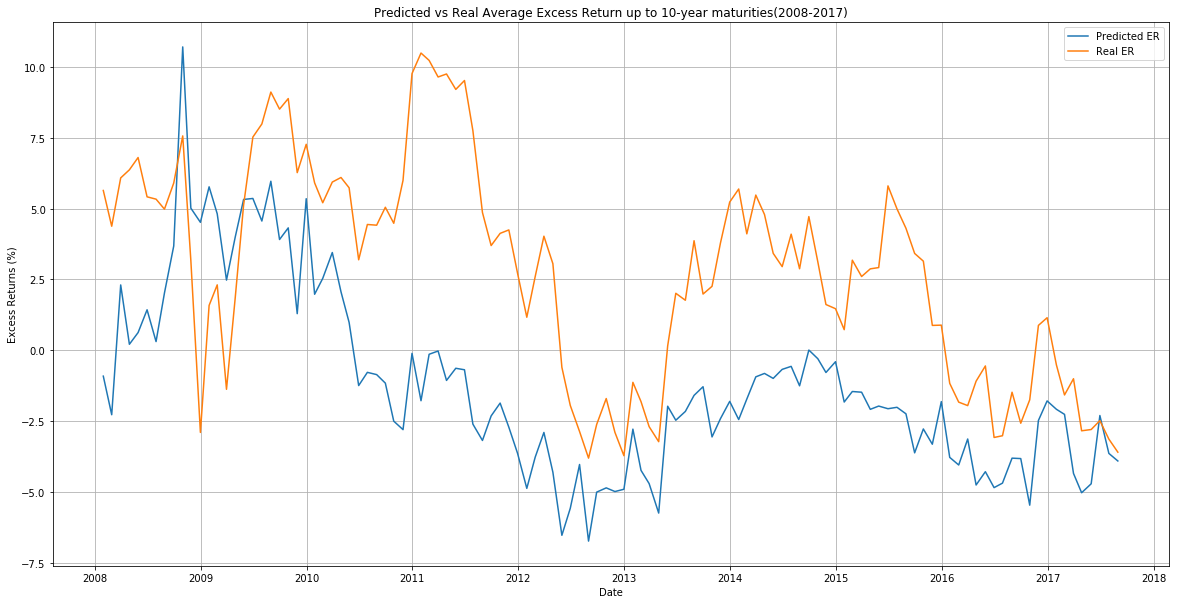

array([-0.51888008, -0.79056412, -0.852604  , -0.83518069, -0.81012876,
       -0.79821834, -0.80171899, -0.81771925, -0.84242578])

In [30]:
plt.figure(figsize=(20,10))
plt.plot(rxt_predict_bar*100, label='Predicted ER')
plt.plot(rxt_bar_test10*100, label='Real ER')
#plt.plot(np.sum(pre*100, axis = 1)/9, label='x')
plt.xlabel("Date")
plt.ylabel("Excess Returns (%)")
plt.legend()
plt.grid(True)
plt.title('Predicted vs Real Average Excess Return up to 10-year maturities(2008-2017)')
plt.show();
R_sq

### Analysis of Predicted VS Actual Excess Returns

In [302]:
# Correlation between actual and predicted average excess returns with train set 1964 - 2008 and test set 2008 - 2018
np.corrcoef(rxt_predict_bar, rxt_bar_test10)

array([[1.        , 0.58926337],
       [0.58926337, 1.        ]])

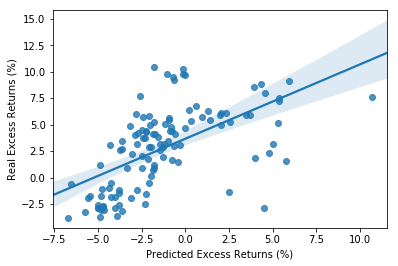

In [303]:
import seaborn as sns
ax = sns.regplot(x=rxt_predict_bar*100, y=rxt_bar_test10*100)
ax.set(xlabel = "Predicted Excess Returns (%)", ylabel = "Real Excess Returns (%)")
plt.show()

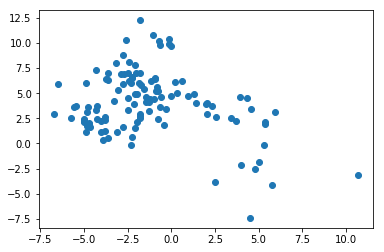

In [304]:
residuals = [rxt_bar_test10[i]*100 - rxt_predict_bar[i]*100 for i in range(len(rxt_predict_bar))]
residuals = pd.DataFrame(residuals)
# plot residuals
plt.scatter(rxt_predict_bar*100, residuals)

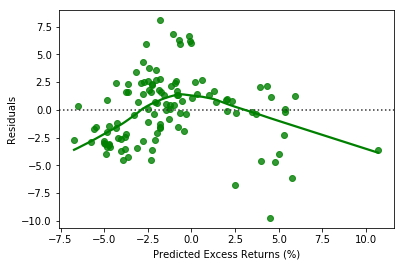

In [305]:
fig = sns.residplot(x=rxt_predict_bar*100, y=rxt_bar_test10*100, lowess=True, color="g")
fig.set(xlabel = 'Predicted Excess Returns (%)', ylabel = 'Residuals')
plt.show()

# Regression for different regimes up to 5-year maturities

## High Inflation period. 1964-1980 

In [306]:
# Compute regression
gamma_65, b_65, reg_coef_65, predicted_65, pre_bar_65, rxt_average_65 = simple_model_regressions(
    '1964-1-1','1980-1-1','1980-1-1','1990-1-1',y, f, rx, 5)

Text(0.5,1,'Coefficients for Excess Returns period 1964-1980')

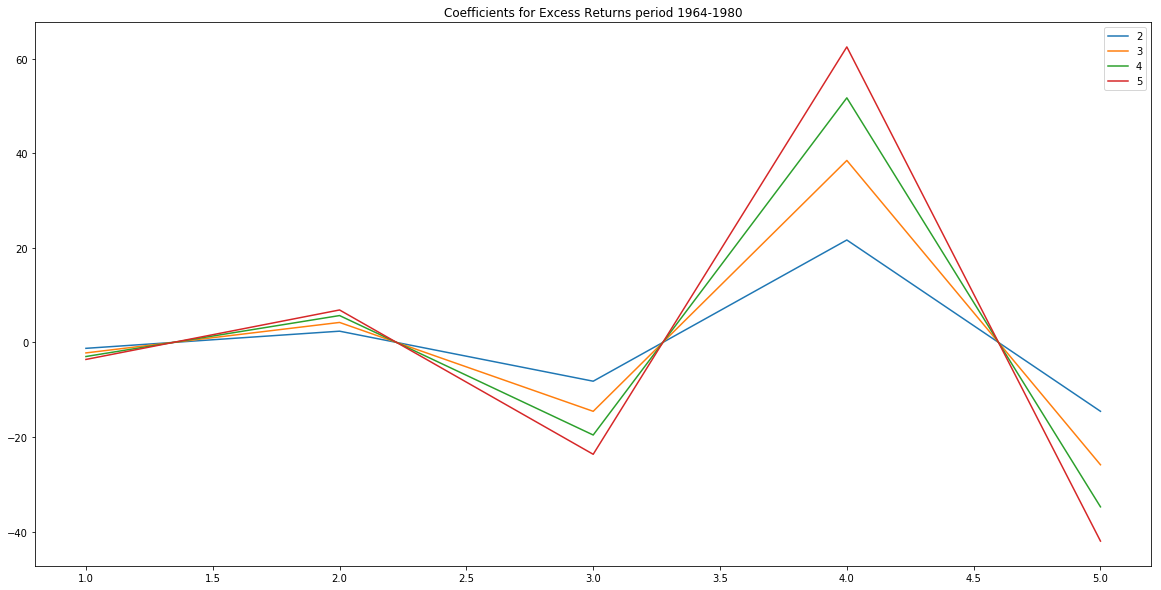

In [307]:
plt.figure(1, figsize = (20,10))
for i in range(4):            
    plt.plot(range(1,6),reg_coef_65[:,i], label = (i+2)  )
plt.legend()
plt.title("Coefficients for Excess Returns period 1964-1980")

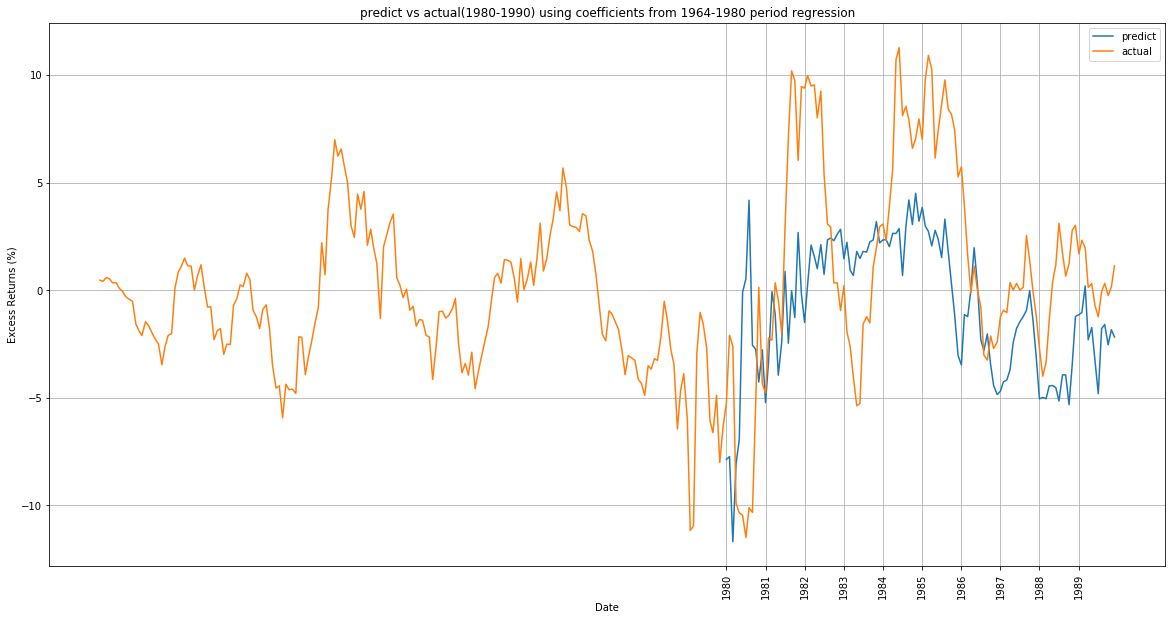

In [308]:
plt.figure(figsize=(20,10))
plt.plot(pre_bar_65*100, label='predict')
plt.plot(rxt_average_65*100, label='actual')
plt.xticks(pre_bar_65.index[::12], rotation = 90)
plt.xlabel("Date")
plt.ylabel("Excess Returns (%)")
plt.legend()
plt.grid(True)
plt.title('predict vs actual(1980-1990) using coefficients from 1964-1980 period regression')
plt.show();

In [309]:
# Correlation of predicted VS actual excess returns
np.corrcoef(pre_bar_65,rxt_average_65[pre_bar_65.index])
print('Correlation: ', np.corrcoef(pre_bar_65,rxt_average_65[pre_bar_65.index])[1,0])

Correlation:  0.4801469704069126


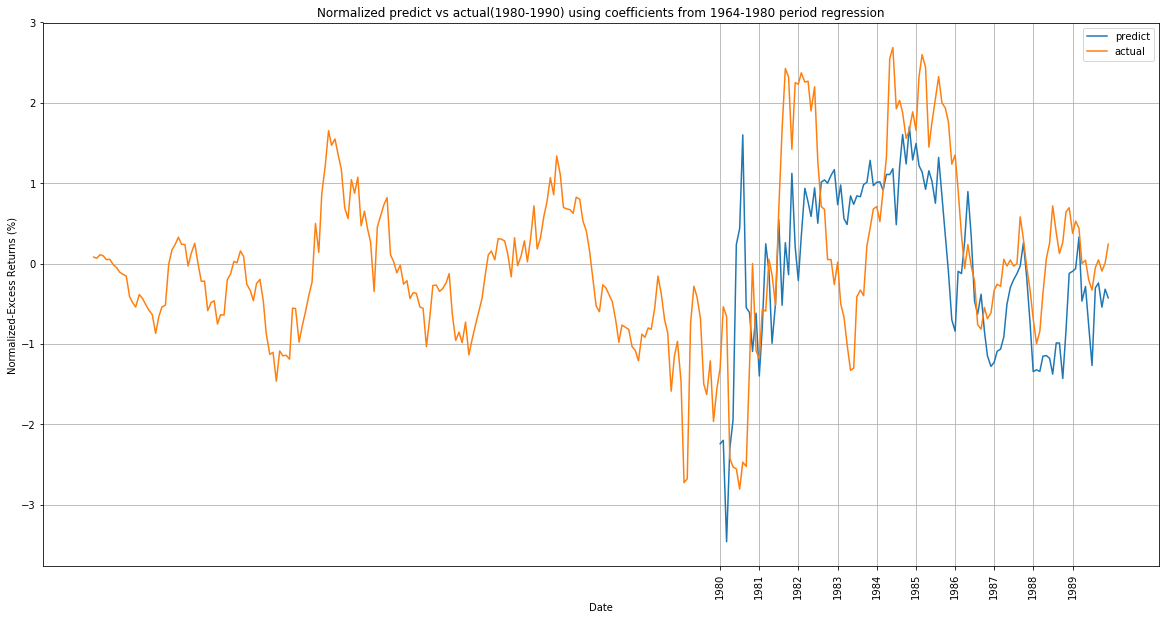

In [310]:
# Normalizing Predictions
def normalize_data(data):
    return ((data - np.mean(data, axis = 0))/np.std(data, axis = 0))
plt.figure(figsize=(20,10))
plt.plot(normalize_data(pre_bar_65), label='predict')
plt.plot(normalize_data(rxt_average_65), label='actual')
plt.xticks(pre_bar_65.index[::12], rotation = 90)
plt.xlabel("Date")
plt.ylabel("Normalized-Excess Returns (%)")
plt.legend()
plt.grid(True)
plt.title('Normalized predict vs actual(1980-1990) using coefficients from 1964-1980 period regression')
plt.show();


In [311]:
# Correlation of predicted VS actual excess returns
print('Correlation: ', np.corrcoef(normalize_data(pre_bar_65),normalize_data(rxt_average_65[pre_bar_65.index]))[1,0])

Correlation:  0.48014697040691245


## FED lowering inflation period. 1980-1990 

In [312]:
# Compute regression
gamma_80, b_80, reg_coef_80, predicted_80, pre_bar_80, rxt_average_80 = simple_model_regressions(
    '1980-1-1','1990-1-1','1990-1-1','2000-1-1',y, f, rx, 5)

Text(0.5,1,'Coefficients for Excess Returns period 1980-1990')

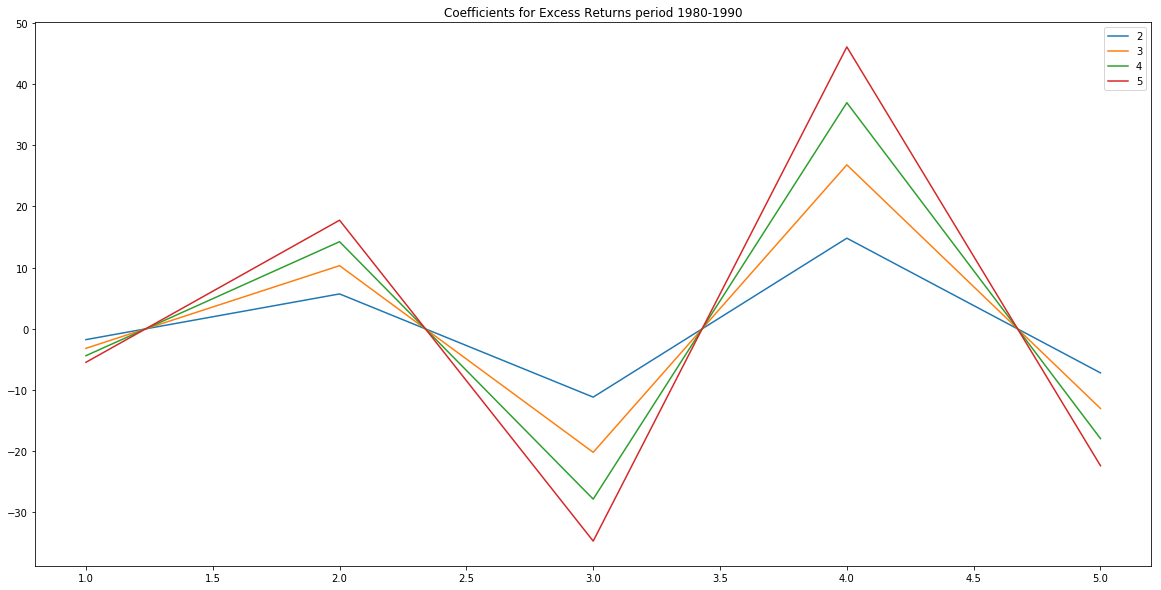

In [313]:
plt.figure(1, figsize = (20,10))
for i in range(4):            
    plt.plot(range(1,6),reg_coef_80[:,i], label = (i+2)  )
plt.legend()
plt.title("Coefficients for Excess Returns period 1980-1990")

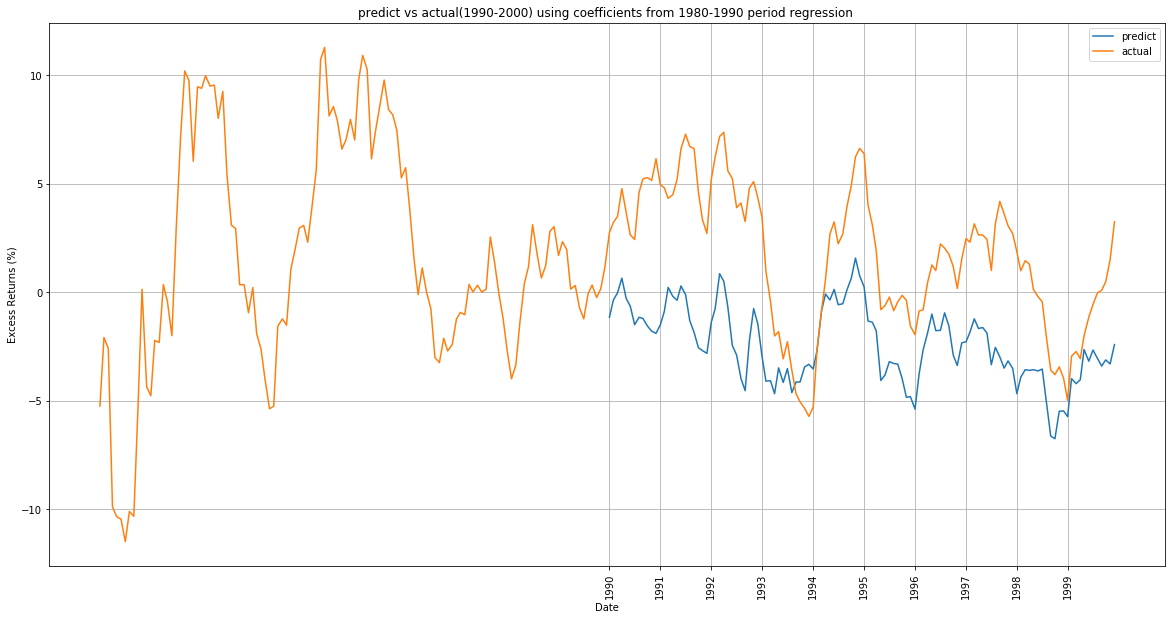

In [314]:
plt.figure(figsize=(20,10))
plt.plot(pre_bar_80*100, label='predict')
plt.plot(rxt_average_80*100, label='actual')
plt.xticks(pre_bar_80.index[::12], rotation = 90)
plt.xlabel("Date")
plt.ylabel("Excess Returns (%)")
plt.legend()
plt.grid(True)
plt.title('predict vs actual(1990-2000) using coefficients from 1980-1990 period regression ')
plt.show();

In [315]:
# Correlation of predicted VS actual excess returns
np.corrcoef(pre_bar_80,rxt_average_80[pre_bar_80.index])
print('Correlation: ', np.corrcoef(pre_bar_80,rxt_average_80[pre_bar_80.index])[1,0])

Correlation:  0.7471554995116784


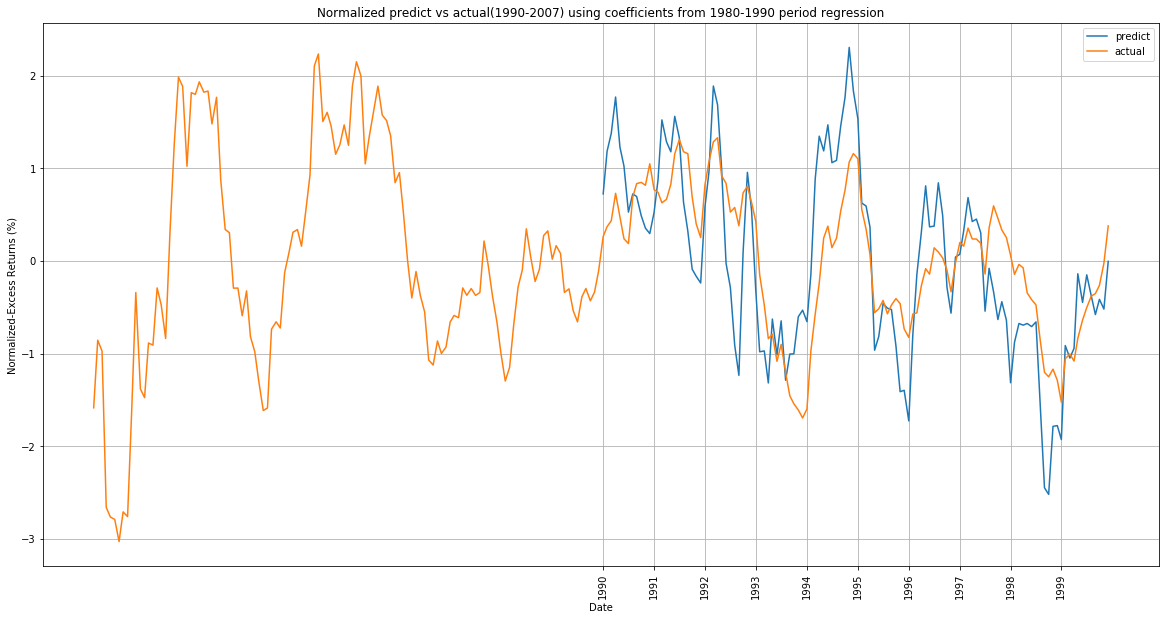

In [316]:
# Normalizing Predictions
def normalize_data(data):
    return ((data - np.mean(data, axis = 0))/np.std(data, axis = 0))
plt.figure(figsize=(20,10))
plt.plot(normalize_data(pre_bar_80), label='predict')
plt.plot(normalize_data(rxt_average_80), label='actual')
plt.xticks(pre_bar_80.index[::12], rotation = 90)
plt.xlabel("Date")
plt.ylabel("Normalized-Excess Returns (%)")
plt.legend()
plt.grid(True)
plt.title('Normalized predict vs actual(1990-2007) using coefficients from 1980-1990 period regression')
plt.show();

## 1990-2007 

In [317]:
# Compute regression
gamma_90, b_90, reg_coef_90, predicted_90, pre_bar_90, rxt_average_90 = simple_model_regressions(
    '1990-1-1','2008-1-1','2008-1-1','2017-9-1',y, f, rx, 5)

Text(0.5,1,'Coefficients for Excess Returns period 2000-2007')

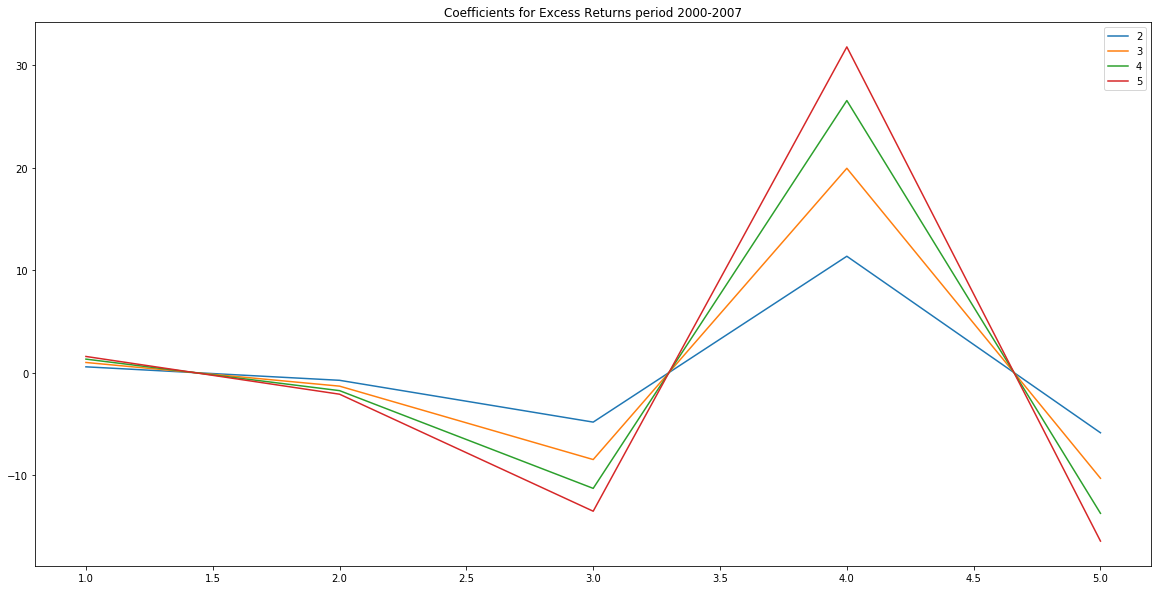

In [318]:
plt.figure(1, figsize = (20,10))
for i in range(4):            
    plt.plot(range(1,6),reg_coef_90[:,i], label = (i+2)  )
plt.legend()
plt.title("Coefficients for Excess Returns period 2000-2007")

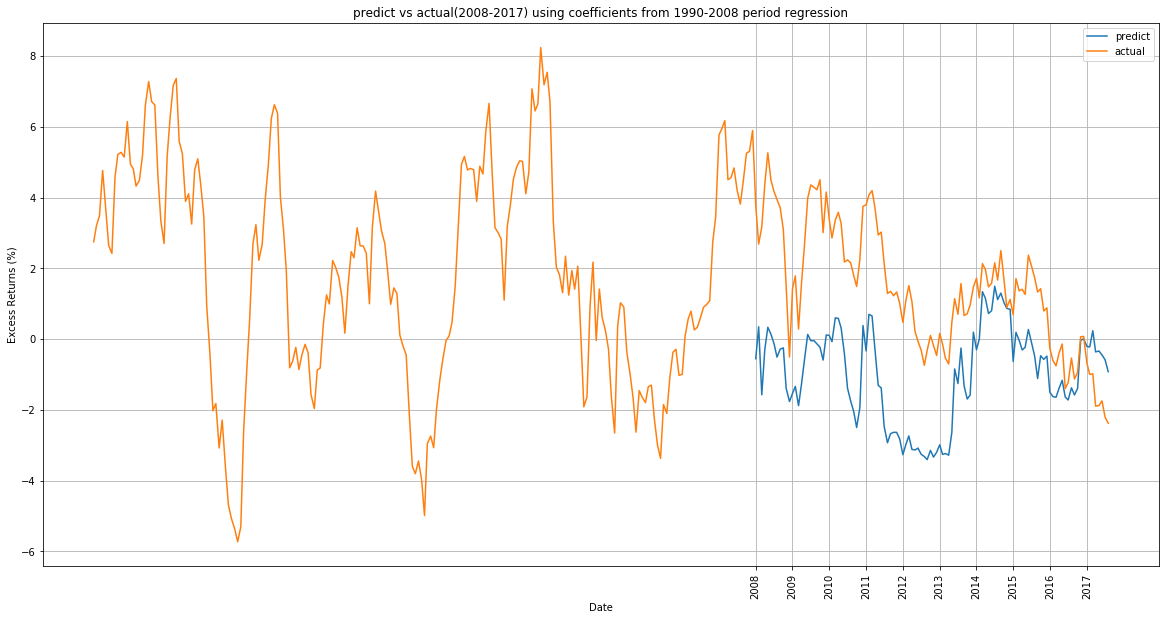

In [319]:
plt.figure(figsize=(20,10))
plt.plot(pre_bar_90*100, label='predict')
plt.plot(rxt_average_90*100, label='actual')
plt.xticks(pre_bar_90.index[::12], rotation = 90)
plt.xlabel("Date")
plt.ylabel("Excess Returns (%)")
plt.legend()
plt.grid(True)
plt.title('predict vs actual(2008-2017) using coefficients from 1990-2008 period regression')
plt.show();

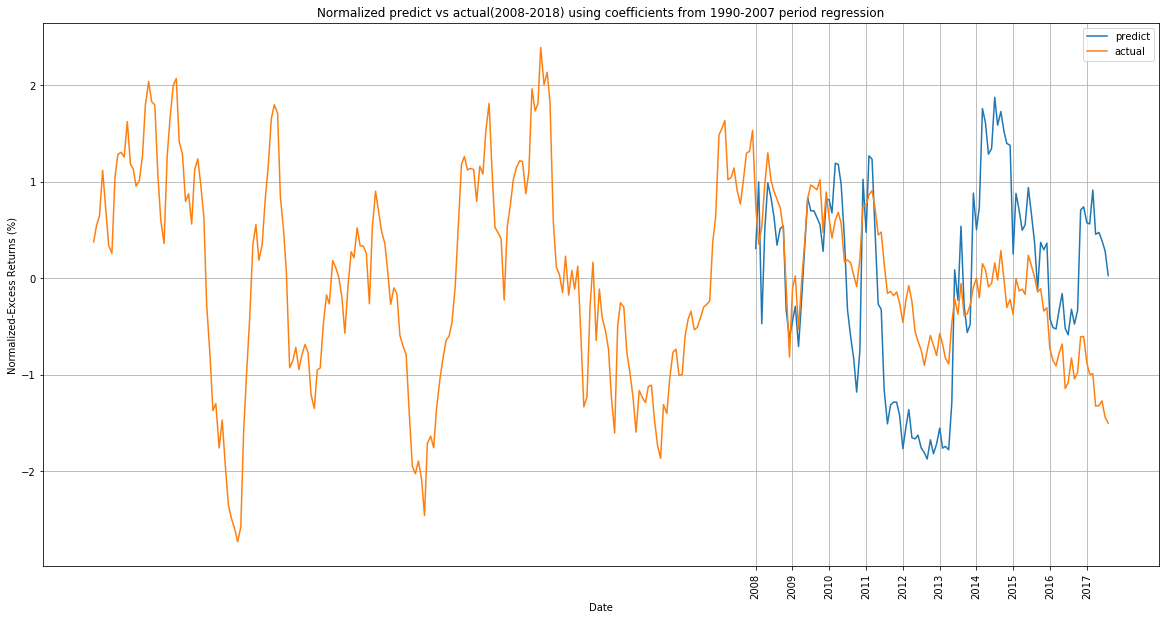

In [320]:
# Normalizing Predictions
def normalize_data(data):
    return ((data - np.mean(data, axis = 0))/np.std(data, axis = 0))
plt.figure(figsize=(20,10))
plt.plot(normalize_data(pre_bar_90), label='predict')
plt.plot(normalize_data(rxt_average_90), label='actual')
plt.xticks(pre_bar_90.index[::12], rotation = 90)
plt.xlabel("Date")
plt.ylabel("Normalized-Excess Returns (%)")
plt.legend()
plt.grid(True)
plt.title('Normalized predict vs actual(2008-2018) using coefficients from 1990-2007 period regression')
plt.show();

In [321]:
# Correlation of predicted VS actual excess returns
np.corrcoef(pre_bar_90,rxt_average_90[pre_bar_90.index])

array([[1.        , 0.44743663],
       [0.44743663, 1.        ]])

In [322]:
print('Correlation: ', np.corrcoef(pre_bar_90,rxt_average_90[pre_bar_90.index])[1,0])

Correlation:  0.4474366317976639


## Post-crisis 2008-2018

In [31]:
# Compute regression
gamma_2008, b_2008, reg_coef_2008, predicted_2008, pre_bar_2008, rxt_average_2008 = simple_model_regressions(
    '2008-1-1','2017-9-1','2008-1-1','2017-9-1',y, f, rx, 5)

Text(0.5,1,'Coefficients for Excess Returns period 2008-2018')

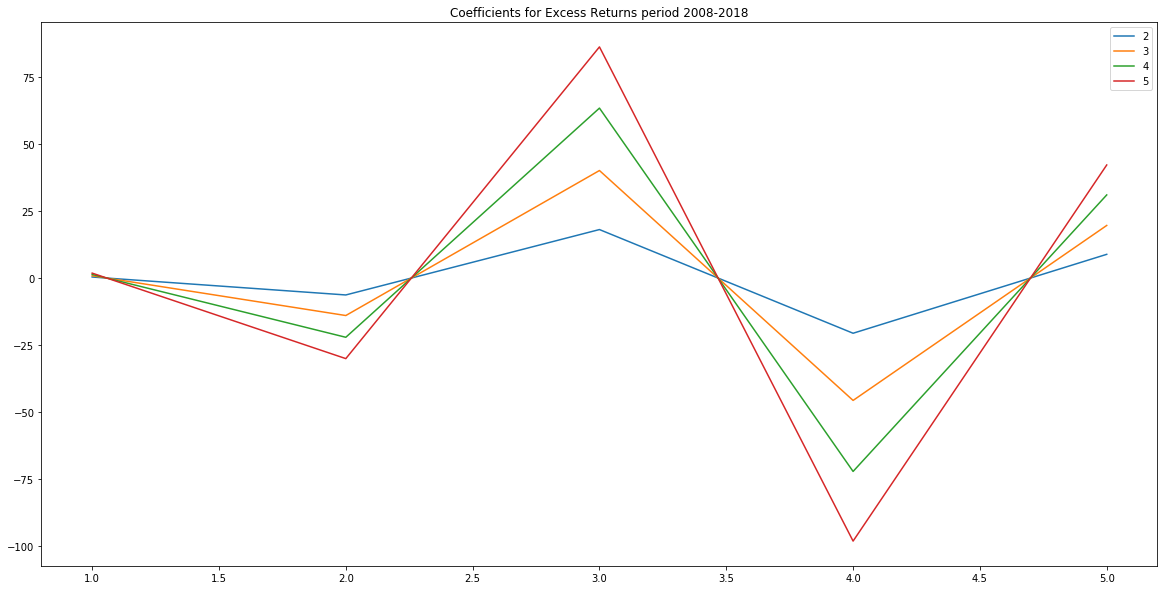

In [32]:
plt.figure(1, figsize = (20,10))
for i in range(4):            
    plt.plot(range(1,6),reg_coef_2008[:,i], label = (i+2)  )
plt.legend()
plt.title("Coefficients for Excess Returns period 2008-2018")

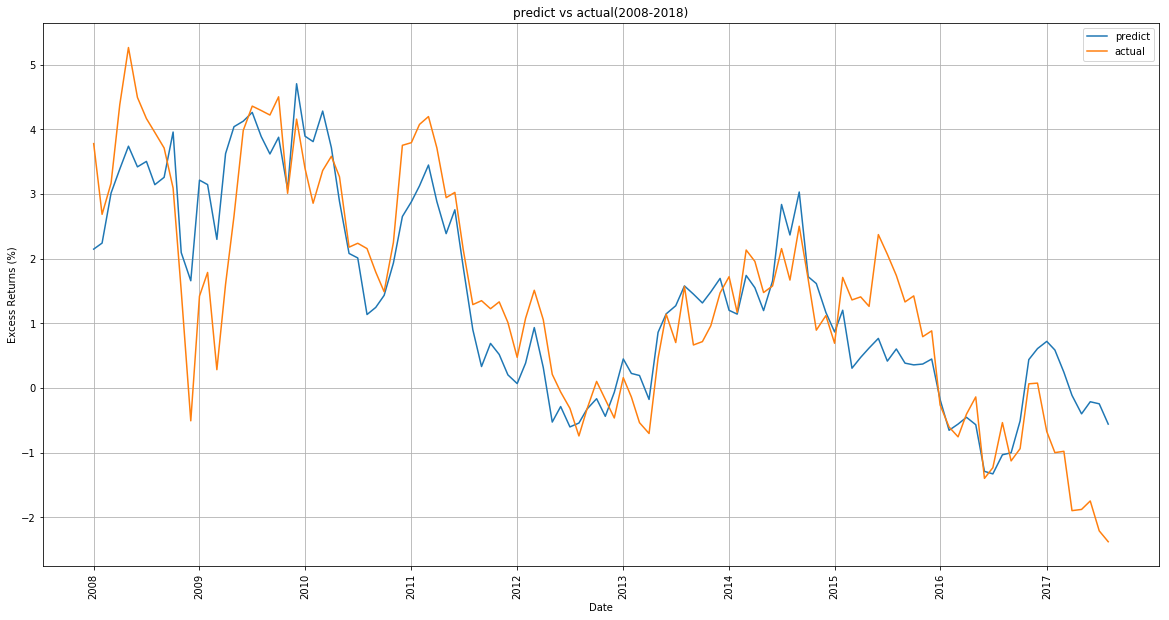

In [33]:
plt.figure(figsize=(20,10))
plt.plot(pre_bar_2008*100, label='predict')
plt.plot(rxt_average_2008*100, label='actual')
plt.xticks(pre_bar_2008.index[::12], rotation = 90)
plt.xlabel("Date")
plt.ylabel("Excess Returns (%)")
plt.legend()
plt.grid(True)
plt.title('predict vs actual(2008-2018)')
plt.show();

In [326]:
# Correlation of predicted VS actual excess returns
np.corrcoef(pre_bar_2008,rxt_average_2008[pre_bar_2008.index])

array([[1.        , 0.87350807],
       [0.87350807, 1.        ]])

## Coefficients Comparison

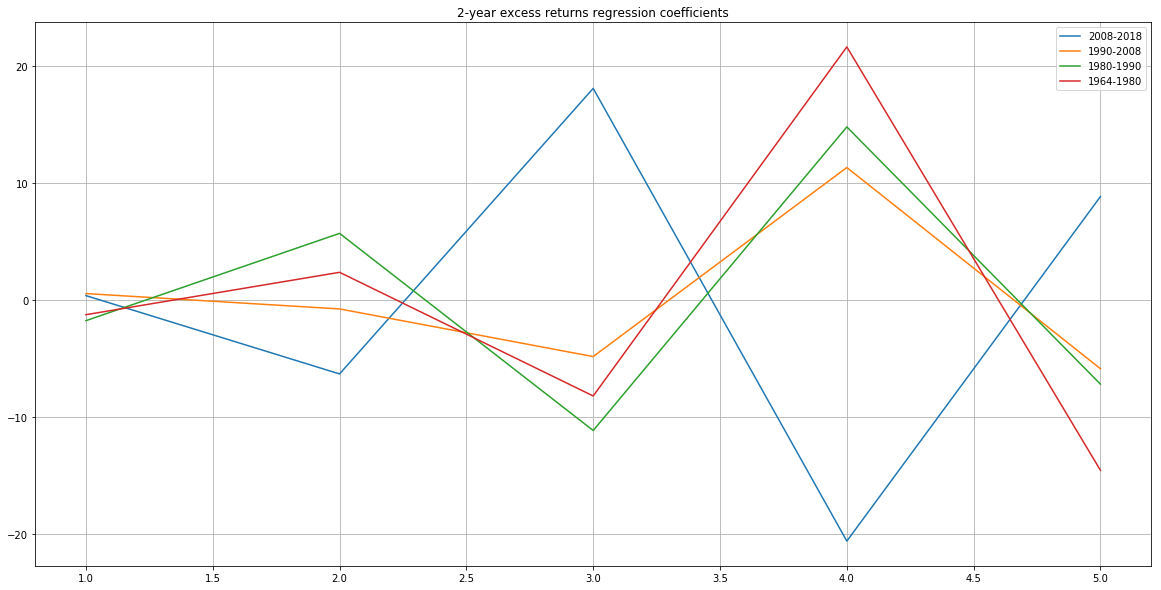

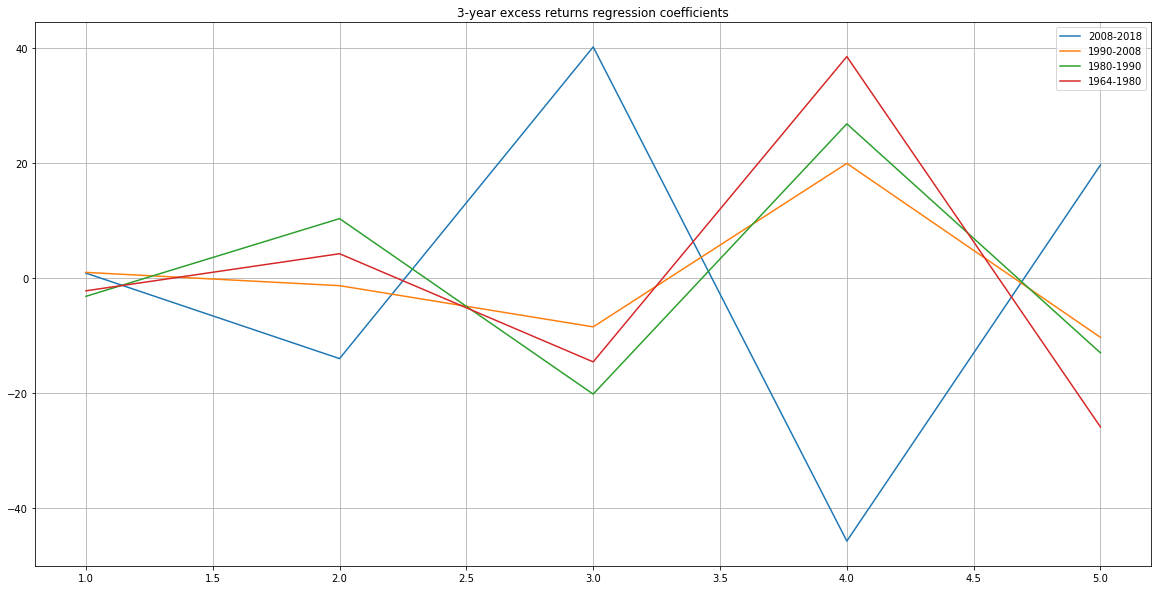

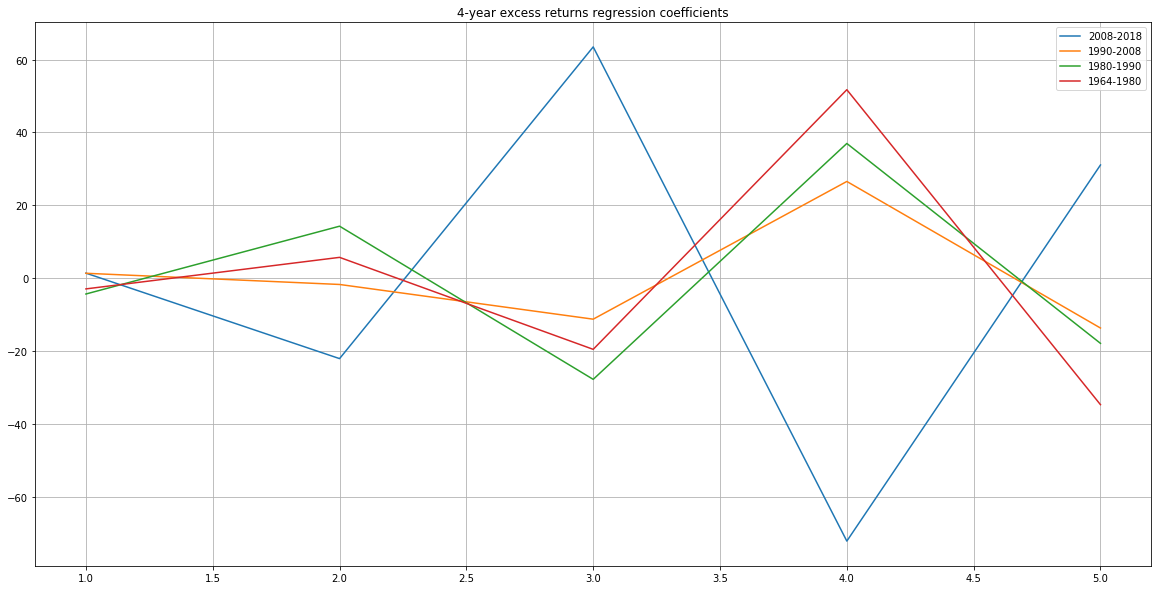

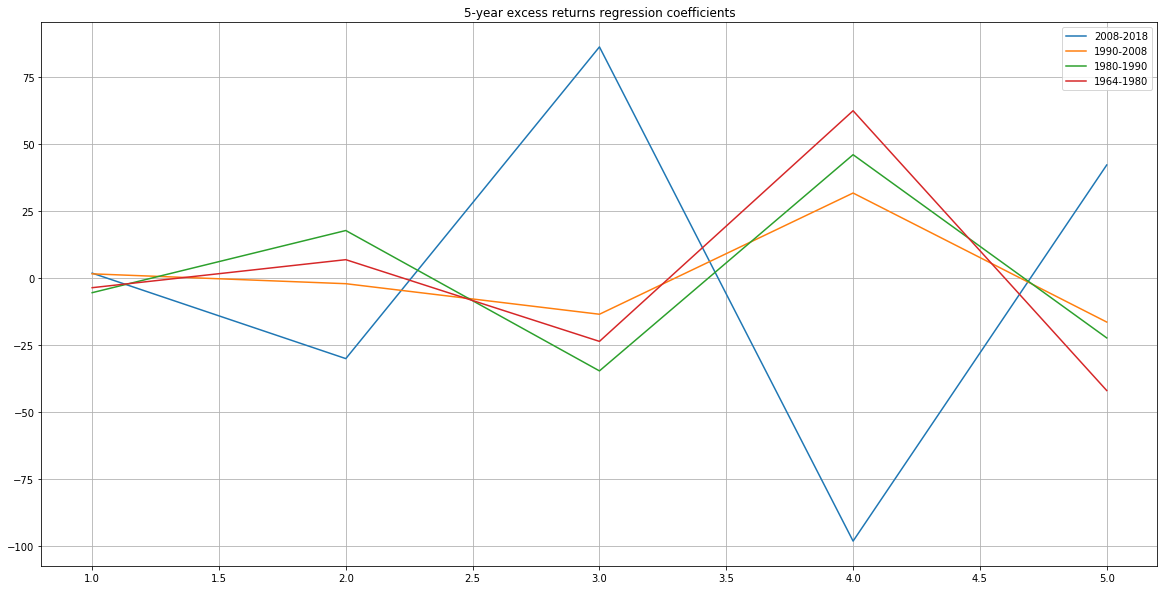

In [327]:
plt.figure(figsize=(20,10))
plt.plot(range(1,6), reg_coef_2008[:,0], label='2008-2018')
plt.plot(range(1,6), reg_coef_90[:,0], label='1990-2008')
plt.plot(range(1,6), reg_coef_80[:,0], label='1980-1990')
plt.plot(range(1,6), reg_coef_65[:,0], label='1964-1980')
plt.legend()
plt.grid(True)
plt.title('2-year excess returns regression coefficients')
plt.show();
plt.figure(figsize=(20,10))
plt.plot(range(1,6), reg_coef_2008[:,1], label='2008-2018')
plt.plot(range(1,6), reg_coef_90[:,1], label='1990-2008')
plt.plot(range(1,6), reg_coef_80[:,1], label='1980-1990')
plt.plot(range(1,6), reg_coef_65[:,1], label='1964-1980')
plt.legend()
plt.grid(True)
plt.title('3-year excess returns regression coefficients')
plt.show();
plt.figure(figsize=(20,10))
plt.plot(range(1,6), reg_coef_2008[:,2], label='2008-2018')
plt.plot(range(1,6), reg_coef_90[:,2], label='1990-2008')
plt.plot(range(1,6), reg_coef_80[:,2], label='1980-1990')
plt.plot(range(1,6), reg_coef_65[:,2], label='1964-1980')
plt.legend()
plt.grid(True)
plt.title('4-year excess returns regression coefficients')
plt.show();
plt.figure(figsize=(20,10))
plt.plot(range(1,6), reg_coef_2008[:,3], label='2008-2018')
plt.plot(range(1,6), reg_coef_90[:,3], label='1990-2008')
plt.plot(range(1,6), reg_coef_80[:,3], label='1980-1990')
plt.plot(range(1,6), reg_coef_65[:,3], label='1964-1980')
plt.legend()
plt.grid(True)
plt.title('5-year excess returns regression coefficients')
plt.show();

# Regression for different regimes up to 10-year maturities

## High Inflation period. 1964-1980 

In [328]:
# Compute regression
gamma_72, b_72, reg_coef_72, predicted_72, pre_bar_72, rxt_average_72 = simple_model_regressions(
    '1972-1-1','1980-1-1','1980-1-1','1990-1-1',y, f, rx, 10)

Text(0.5,1,'Coefficients for Excess Returns period 1972-1980')

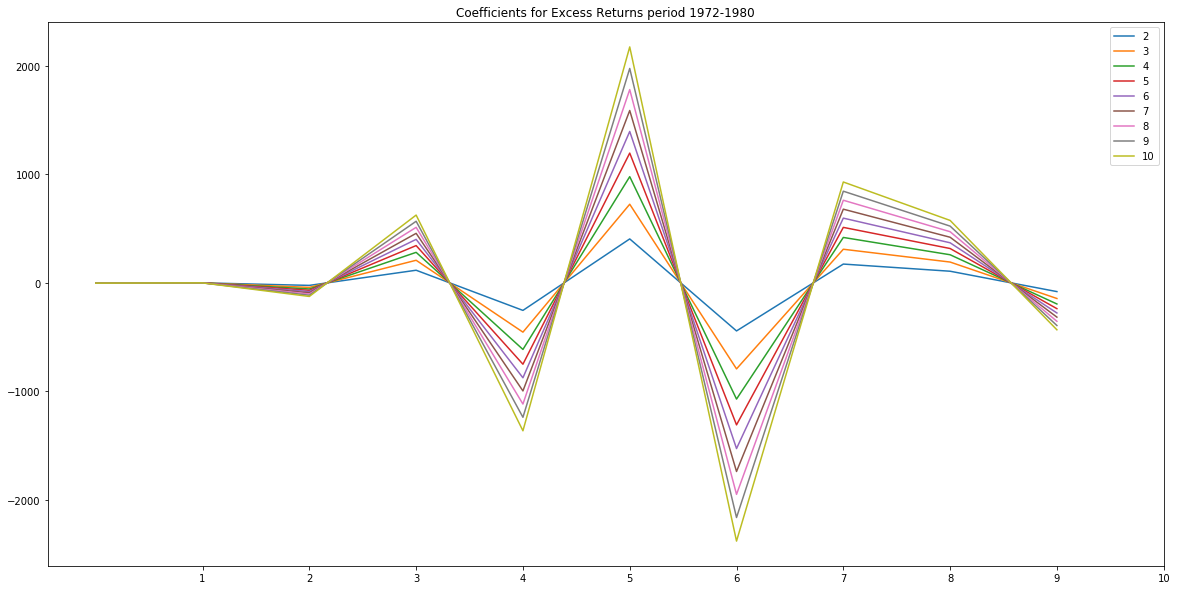

In [329]:
plt.figure(1, figsize = (20,10))
for i in range(9):            
    plt.plot(reg_coef_72[:,i], label = (i+2))
plt.xticks(range(1,11))
plt.legend()
plt.title("Coefficients for Excess Returns period 1972-1980")

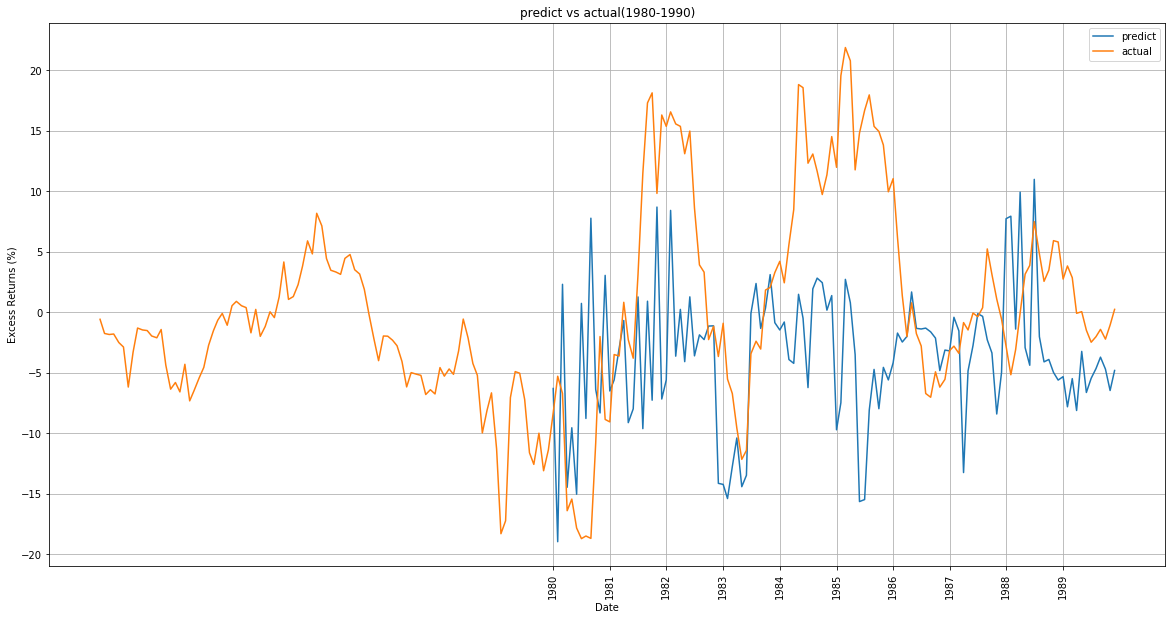

In [330]:
plt.figure(figsize=(20,10))
plt.plot(pre_bar_72*100, label='predict')
plt.plot(rxt_average_72*100, label='actual')
plt.xticks(pre_bar_72.index[::12], rotation = 90)
plt.xlabel("Date")
plt.ylabel("Excess Returns (%)")
plt.legend()
plt.grid(True)
plt.title('predict vs actual(1980-1990)')
plt.show();

In [331]:
# Correlation of predicted VS actual excess returns
np.corrcoef(pre_bar_72,rxt_average_72[pre_bar_72.index])

array([[1.        , 0.17678103],
       [0.17678103, 1.        ]])

## FED lowering inflation period. 1980-1990 

In [332]:
# Compute regression
gamma_80_long, b_80_long, reg_coef_80_long, predicted_80_long, pre_bar_80_long, rxt_average_80_long = simple_model_regressions(
    '1980-1-1','1990-1-1','1990-1-1','2000-1-1',y, f, rx, 10)

Text(0.5,1,'Coefficients for Excess Returns period 1980-1990')

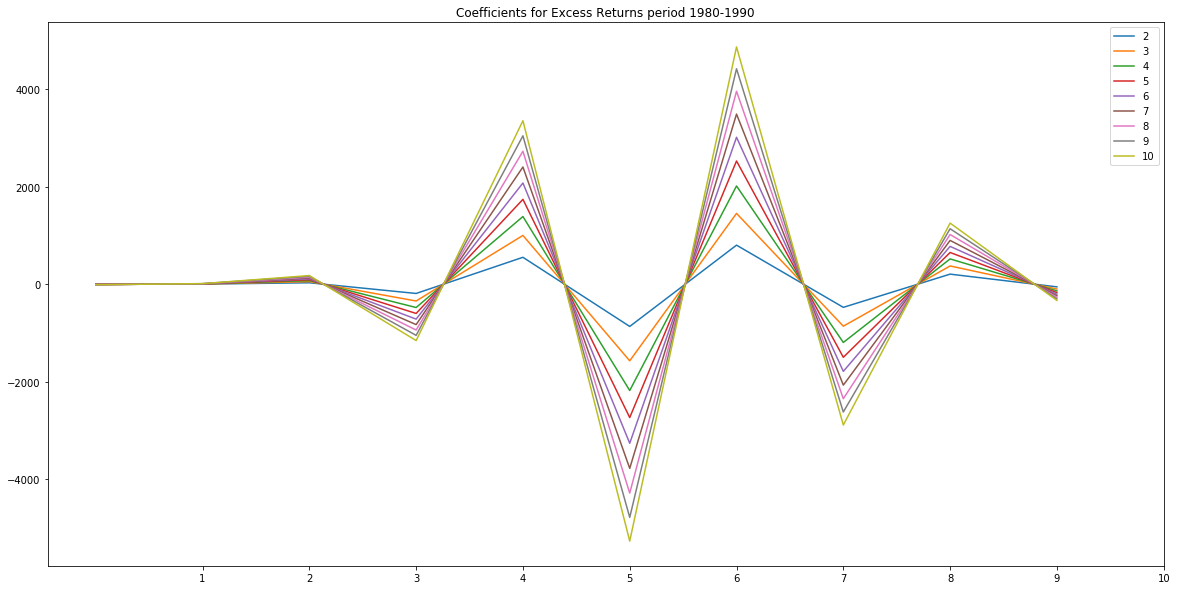

In [333]:
plt.figure(1, figsize = (20,10))
for i in range(9):            
    plt.plot(reg_coef_80_long[:,i], label = (i+2))
plt.xticks(range(1,11))
plt.legend()
plt.title("Coefficients for Excess Returns period 1980-1990")

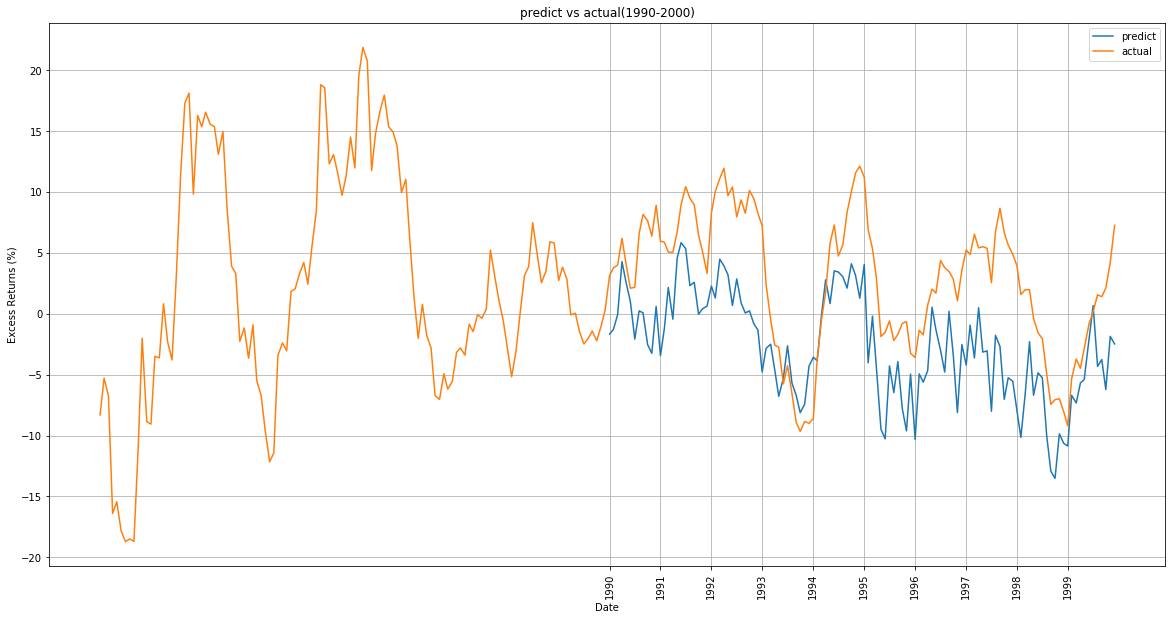

In [334]:
plt.figure(figsize=(20,10))
plt.plot(pre_bar_80_long*100, label='predict')
plt.plot(rxt_average_80_long*100, label='actual')
plt.xticks(pre_bar_80_long.index[::12], rotation = 90)
plt.xlabel("Date")
plt.ylabel("Excess Returns (%)")
plt.legend()
plt.grid(True)
plt.title('predict vs actual(1990-2000)')
plt.show();

In [335]:
# Correlation of predicted VS actual excess returns
np.corrcoef(pre_bar_80_long,rxt_average_80_long[pre_bar_80_long.index])

array([[1.        , 0.73780242],
       [0.73780242, 1.        ]])

## 1990-2007 

In [336]:
# Compute regression
gamma_90_long, b_90_long, reg_coef_90_long, predicted_90_long, pre_bar_90_long, rxt_average_90_long = simple_model_regressions(
    '1990-1-1','2008-1-1','2008-1-1','2017-9-1',y, f, rx, 10)

Text(0.5,1,'Coefficients for Excess Returns period 2000-2007')

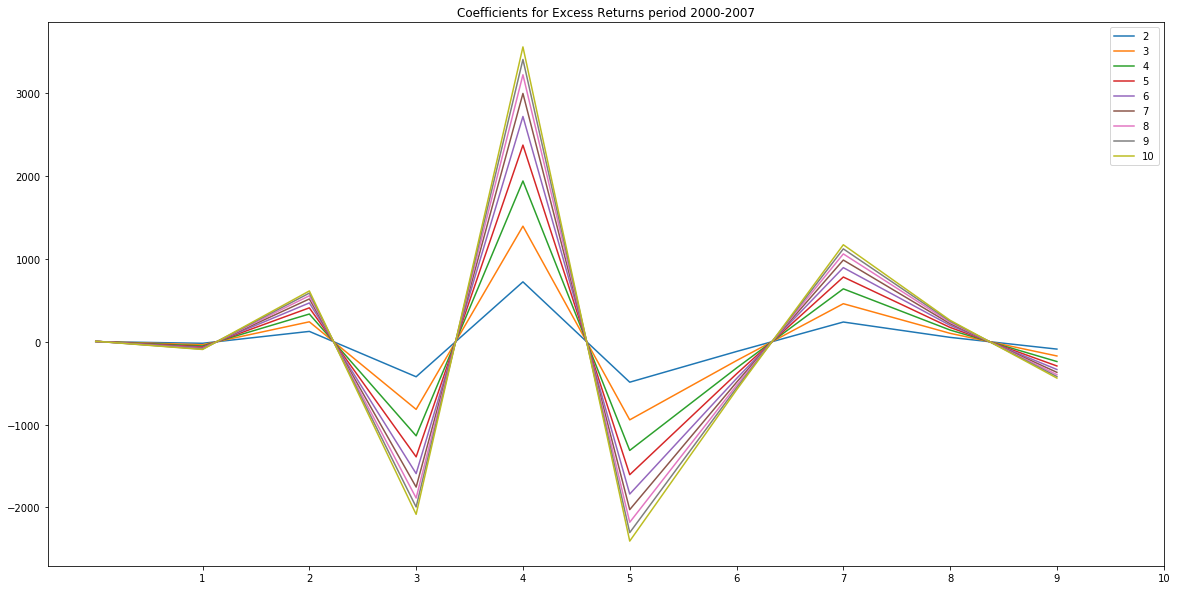

In [337]:
plt.figure(1, figsize = (20,10))
for i in range(9):            
    plt.plot(reg_coef_90_long[:,i], label = (i+2))
plt.xticks(range(1,11))
plt.legend()
plt.title("Coefficients for Excess Returns period 2000-2007")

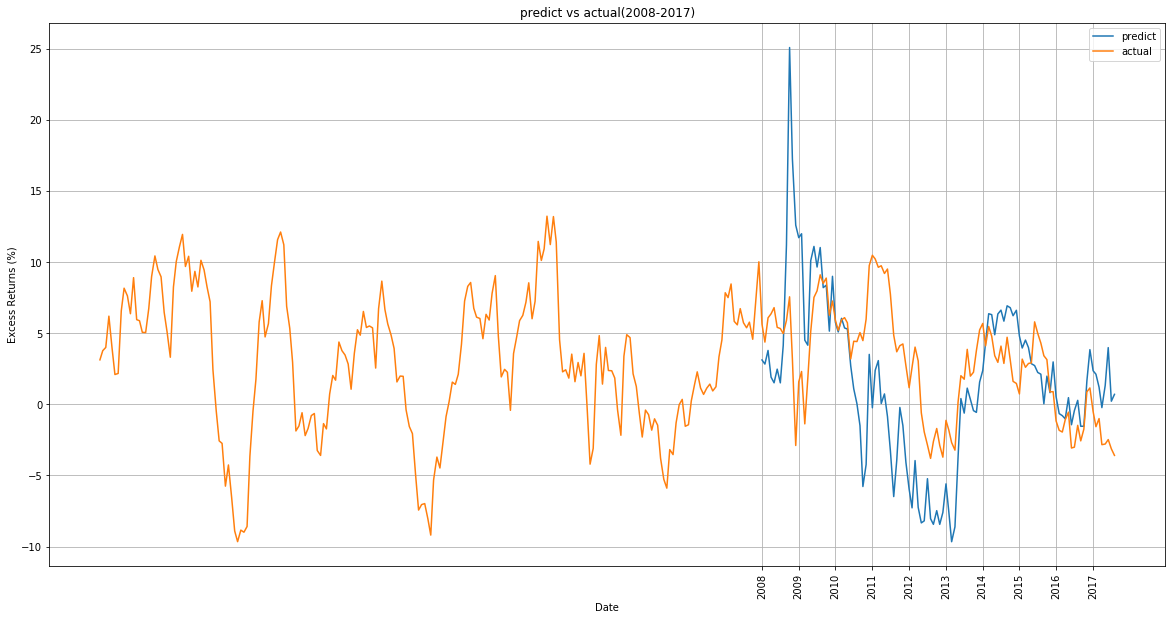

In [338]:
plt.figure(figsize=(20,10))
plt.plot(pre_bar_90_long*100, label='predict')
plt.plot(rxt_average_90_long*100, label='actual')
plt.xticks(pre_bar_90_long.index[::12], rotation = 90)
plt.xlabel("Date")
plt.ylabel("Excess Returns (%)")
plt.legend()
plt.grid(True)
plt.title('predict vs actual(2008-2017)')
plt.show();

In [339]:
# Correlation of predicted VS actual excess returns
np.corrcoef(pre_bar_90_long,rxt_average_90_long[pre_bar_90_long.index])

array([[1.        , 0.42772322],
       [0.42772322, 1.        ]])

## Post-crisis 2008-2018

In [340]:
# Compute regression
gamma_2008_long, b_2008_long, reg_coef_2008_long, predicted_2008_long, pre_bar_2008_long, rxt_average_2008_long = simple_model_regressions(
    '2008-1-1','2017-9-1','2008-1-1','2017-9-1',y, f, rx, 10)

Text(0.5,1,'Coefficients for Excess Returns period 2008-2018')

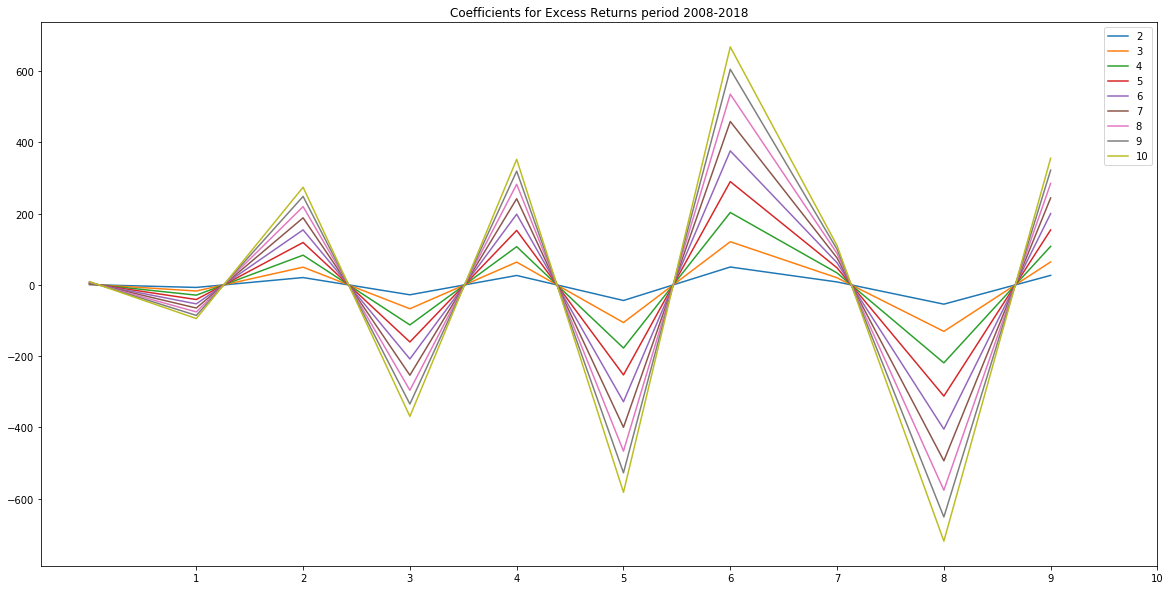

In [341]:
plt.figure(1, figsize = (20,10))
for i in range(9):            
    plt.plot(reg_coef_2008_long[:,i], label = (i+2))
plt.xticks(range(1,11))
plt.legend()
plt.title("Coefficients for Excess Returns period 2008-2018")

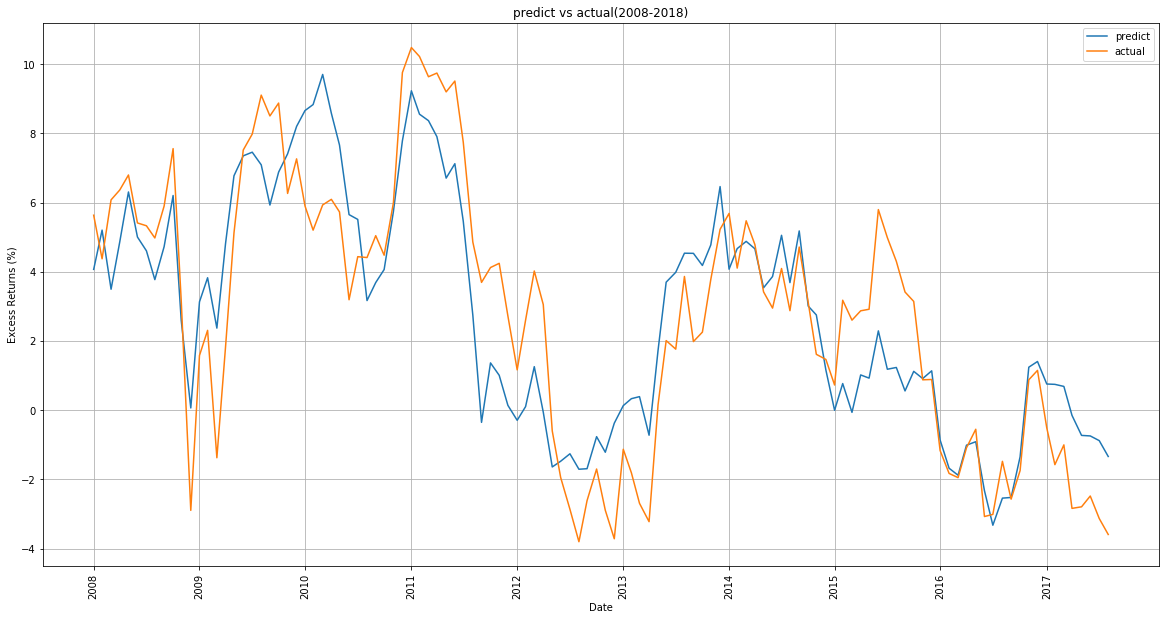

In [342]:
plt.figure(figsize=(20,10))
plt.plot(pre_bar_2008_long*100, label='predict')
plt.plot(rxt_average_2008_long*100, label='actual')
plt.xticks(pre_bar_2008_long.index[::12], rotation = 90)
plt.xlabel("Date")
plt.ylabel("Excess Returns (%)")
plt.legend()
plt.grid(True)
plt.title('predict vs actual(2008-2018)')
plt.show();

In [343]:
# Correlation of predicted VS actual excess returns
np.corrcoef(pre_bar_2008_long,rxt_average_2008_long[pre_bar_2008_long.index])

array([[1.        , 0.86542034],
       [0.86542034, 1.        ]])

## Coefficients Comparison

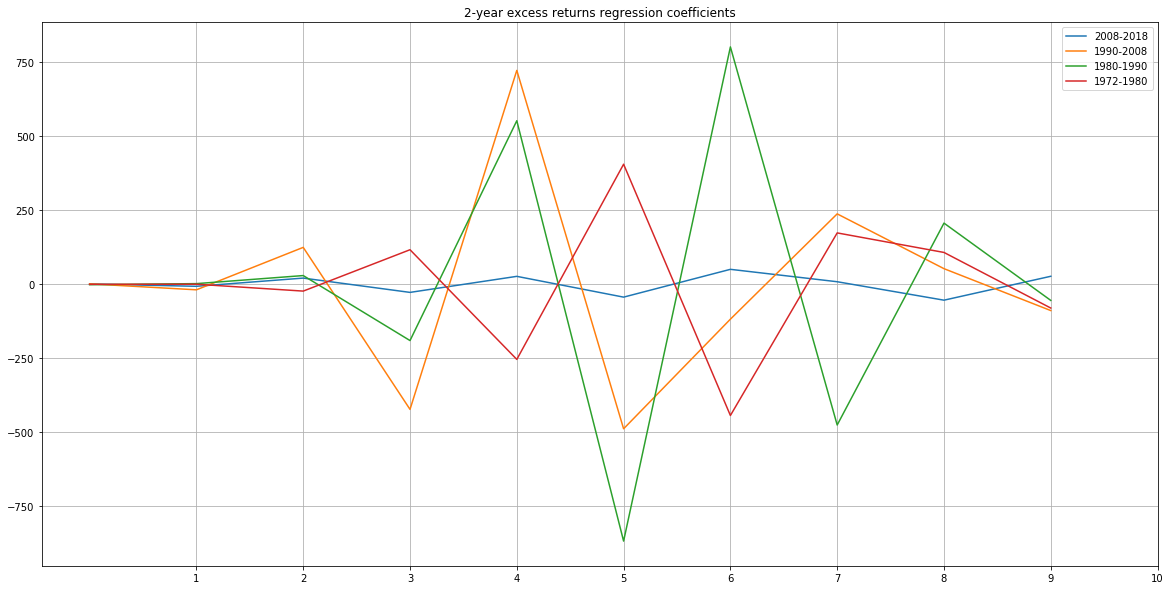

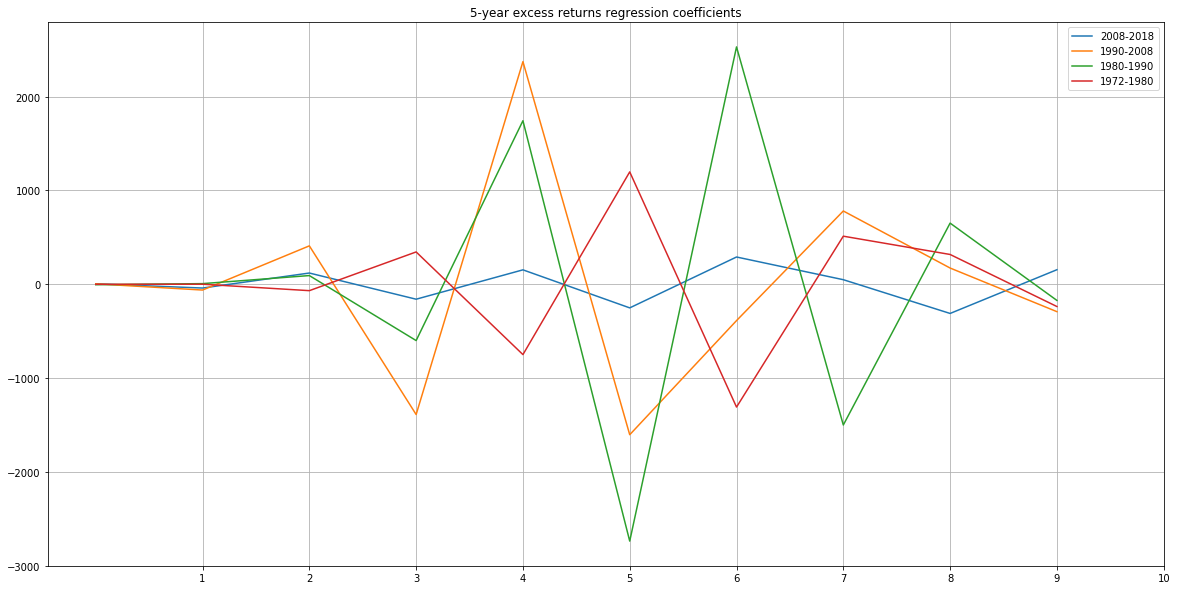

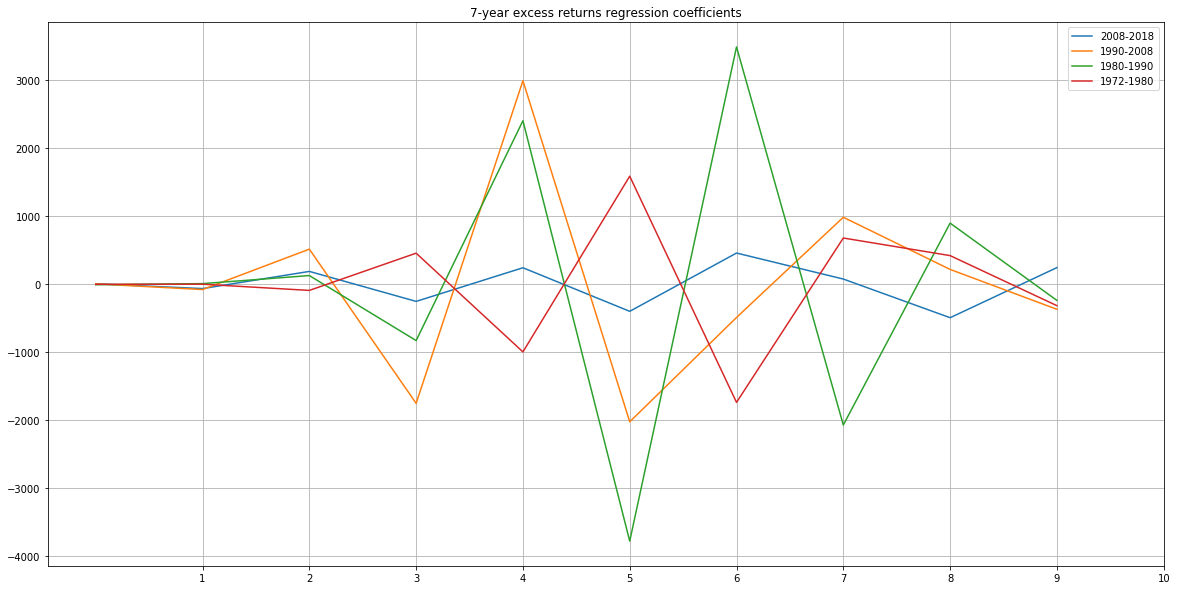

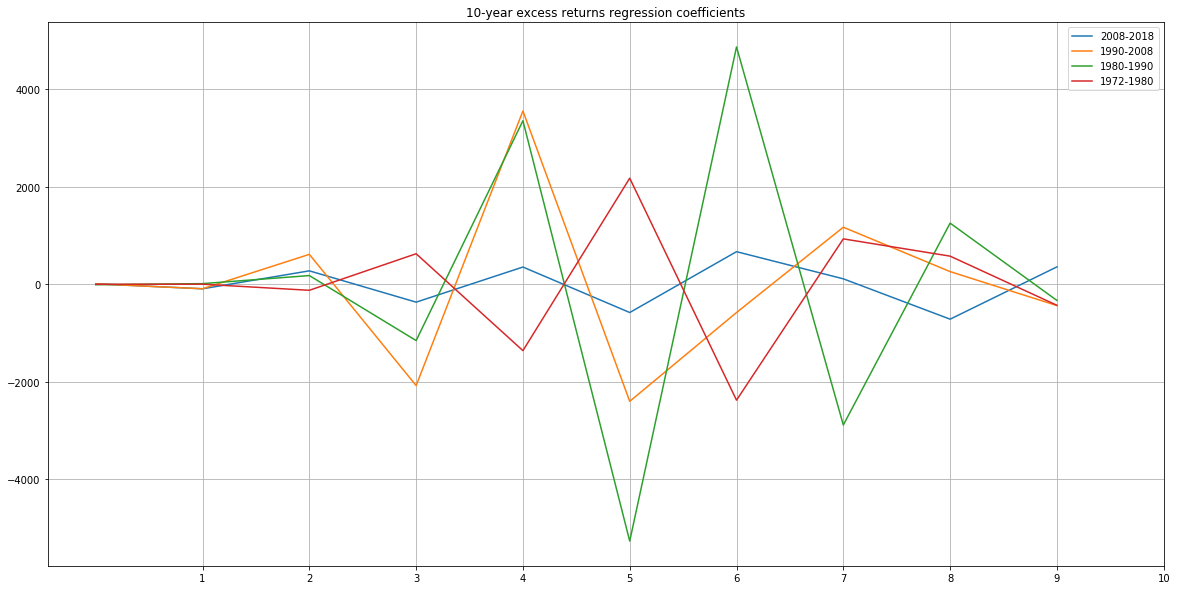

In [344]:
plt.figure(figsize=(20,10))
plt.plot(reg_coef_2008_long[:,0], label='2008-2018')
plt.plot(reg_coef_90_long[:,0], label='1990-2008')
plt.plot(reg_coef_80_long[:,0], label='1980-1990')
plt.plot(reg_coef_72[:,0], label='1972-1980')
plt.xticks(range(1,11))
plt.legend()
plt.grid(True)
plt.title('2-year excess returns regression coefficients')
plt.show();
plt.figure(figsize=(20,10))
plt.plot(reg_coef_2008_long[:,3], label='2008-2018')
plt.plot(reg_coef_90_long[:,3], label='1990-2008')
plt.plot(reg_coef_80_long[:,3], label='1980-1990')
plt.plot(reg_coef_72[:,3], label='1972-1980')
plt.xticks(range(1,11))
plt.legend()
plt.grid(True)
plt.title('5-year excess returns regression coefficients')
plt.show();
plt.figure(figsize=(20,10))
plt.plot(reg_coef_2008_long[:,5], label='2008-2018')
plt.plot(reg_coef_90_long[:,5], label='1990-2008')
plt.plot(reg_coef_80_long[:,5], label='1980-1990')
plt.plot(reg_coef_72[:,5], label='1972-1980')
plt.xticks(range(1,11))
plt.legend()
plt.grid(True)
plt.title('7-year excess returns regression coefficients')
plt.show();
plt.figure(figsize=(20,10))
plt.plot(reg_coef_2008_long[:,8], label='2008-2018')
plt.plot(reg_coef_90_long[:,8], label='1990-2008')
plt.plot(reg_coef_80_long[:,8], label='1980-1990')
plt.plot(reg_coef_72[:,8], label='1972-1980')
plt.xticks(range(1,11))
plt.legend()
plt.grid(True)
plt.title('10-year excess returns regression coefficients')
plt.show();

# Rolling regressions. 10-year period, 1-year moving window

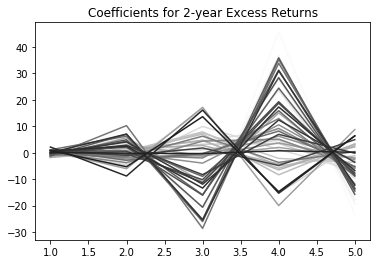

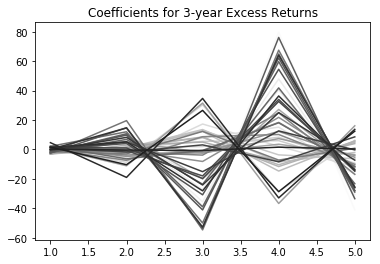

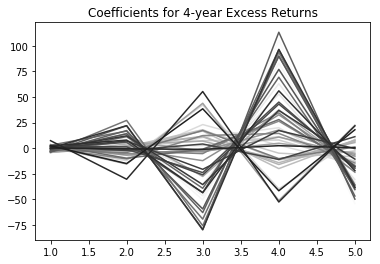

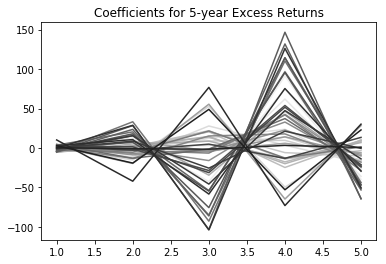

In [345]:
count = 0
for i,j in zip(rx['1964-1-1':'2007-9-1':12].index, rx['1974-1-1':'2017-9-1':12].index):
    count += 1
    g_roll, b_x_roll, reg_co_roll, pre_roll, pre_bar_roll, rxt_average_roll = (
        simple_model_regressions(i,j,i,j,y, f, rx, 5))
    plt.figure(1)
    plt.plot(range(1,6),reg_co_roll[:,0], color = str(1-0.02*count))
    plt.title("Coefficients for 2-year Excess Returns")
    plt.figure(2)
    plt.plot(range(1,6),reg_co_roll[:,1], color = str(1-0.02*count))
    plt.title("Coefficients for 3-year Excess Returns")
    plt.figure(3)
    plt.plot(range(1,6),reg_co_roll[:,2], color = str(1-0.02*count))
    plt.title("Coefficients for 4-year Excess Returns")
    plt.figure(4)
    plt.plot(range(1,6),reg_co_roll[:,3], color = str(1-0.02*count))
    plt.title("Coefficients for 5-year Excess Returns")


# Normalizing Predicted Values 

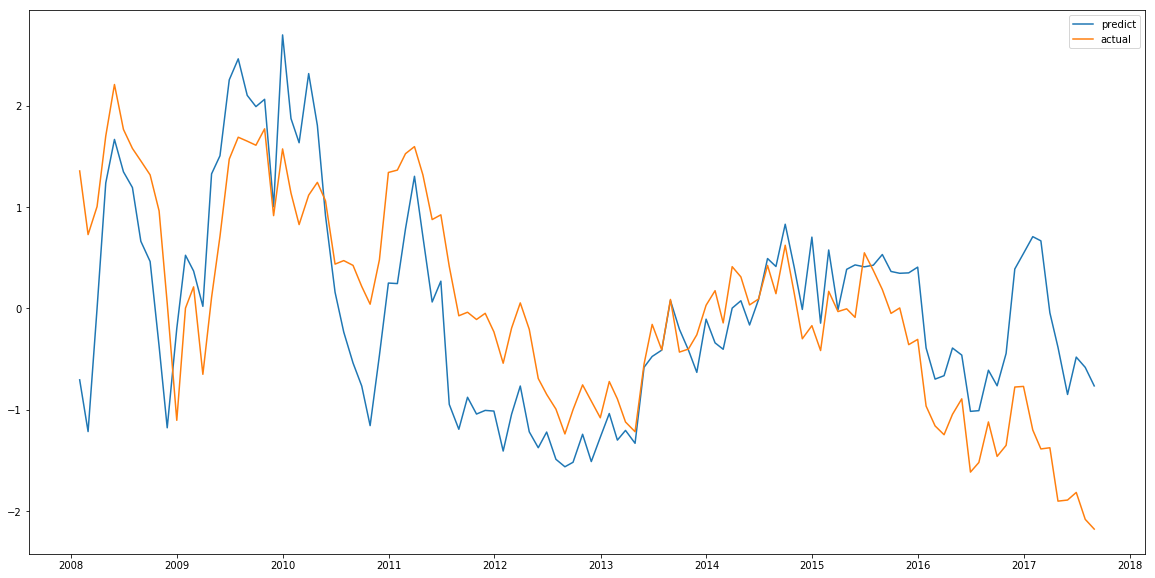

In [346]:
# Normalize results using Z-score. (X-mu)/sigma
g_norm, b_x_norm, reg_co_norm, pre_norm, pre_bar_norm, rxt_average_norm = (
    simple_model_regressions('1964-1-1','2008-1-1','2008-1-1','2017-9-1',y, f, rx, 5))
normalized_real = ((rxt_average_norm[pre_norm.index] - 
                   np.mean(rxt_average_norm[pre_norm.index], axis = 0))/
                   np.std(rxt_average_norm[pre_norm.index], axis = 0))
normalized_prediction = (pre_bar_norm - np.mean(pre_bar_norm, axis = 0))/np.std(pre_bar_norm, axis = 0)
plt.figure(figsize=(20,10))
plt.plot(normalized_prediction, label='predict')
plt.plot(normalized_real, label='actual')
plt.legend()
plt.show()



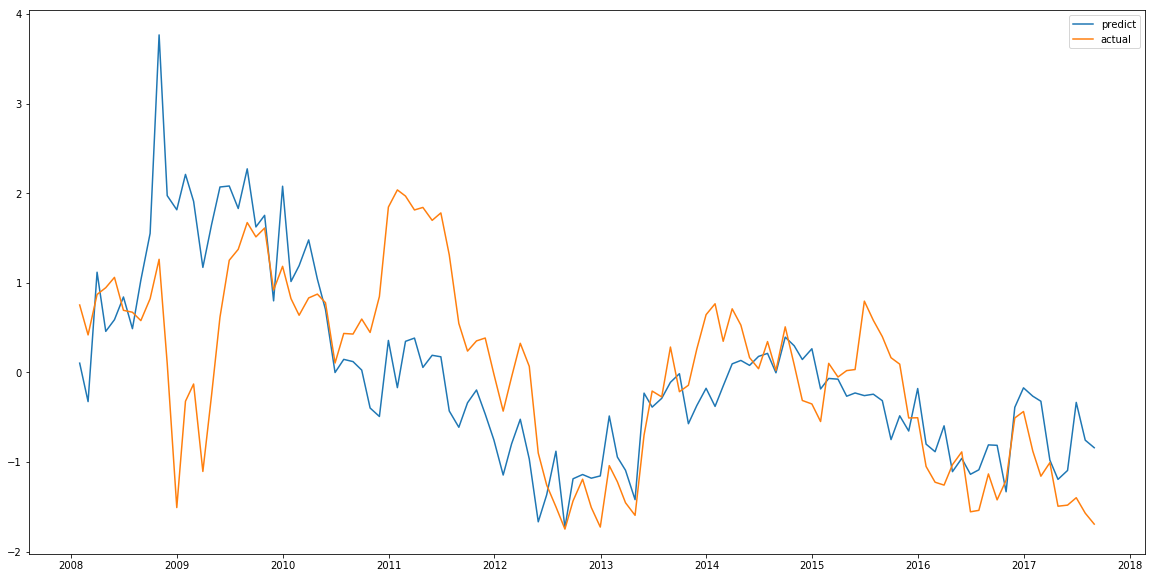

In [347]:
# Normalize results using Z-score. (X-mu)/sigma
g_norm, b_x_norm, reg_co_norm, pre_norm, pre_bar_norm, rxt_average_norm = (
    simple_model_regressions('1972-1-1','2008-1-1','2008-1-1','2017-9-1',y, f, rx, 10))
normalized_real = ((rxt_average_norm[pre_norm.index] - 
                   np.mean(rxt_average_norm[pre_norm.index], axis = 0))/
                   np.std(rxt_average_norm[pre_norm.index], axis = 0))
normalized_prediction = (pre_bar_norm - np.mean(pre_bar_norm, axis = 0))/np.std(pre_bar_norm, axis = 0)
plt.figure(figsize=(20,10))
plt.plot(normalized_prediction, label='predict')
plt.plot(normalized_real, label='actual')
plt.legend()
plt.show()

# Term Premium Analysis. Moving averages 

In [348]:
g_ma, b_x_ma, reg_co_ma, pre_ma, pre_bar_ma, rxt_average_ma = (
    simple_model_regressions('1964-1-1','2017-9-1','1964-1-1','2017-9-1',y, f, rx, 5))

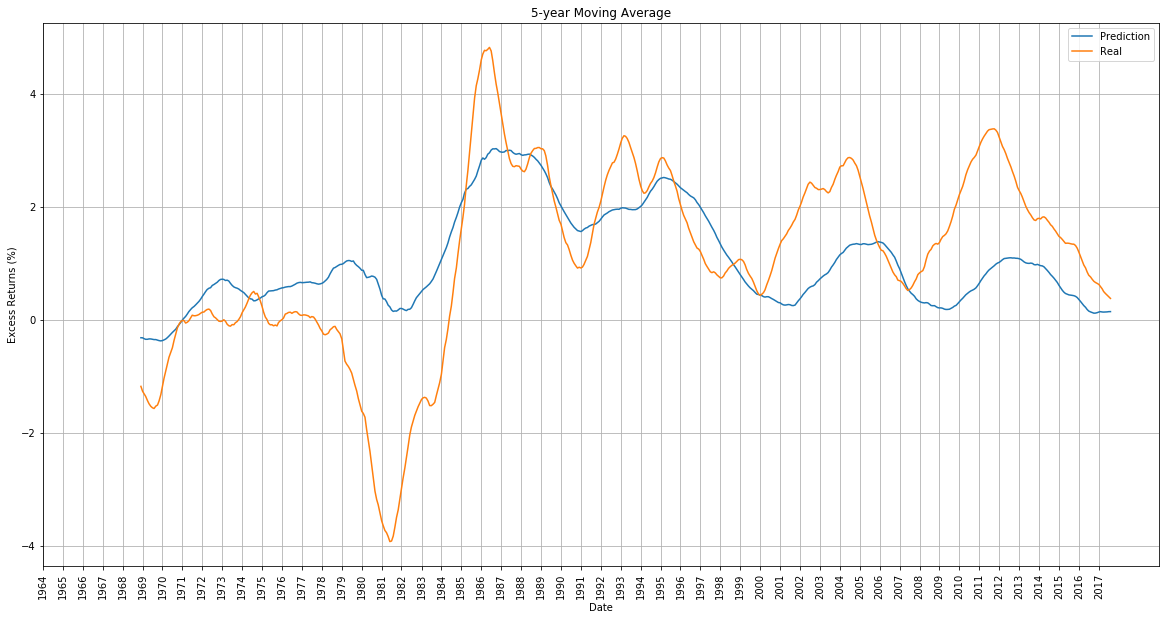

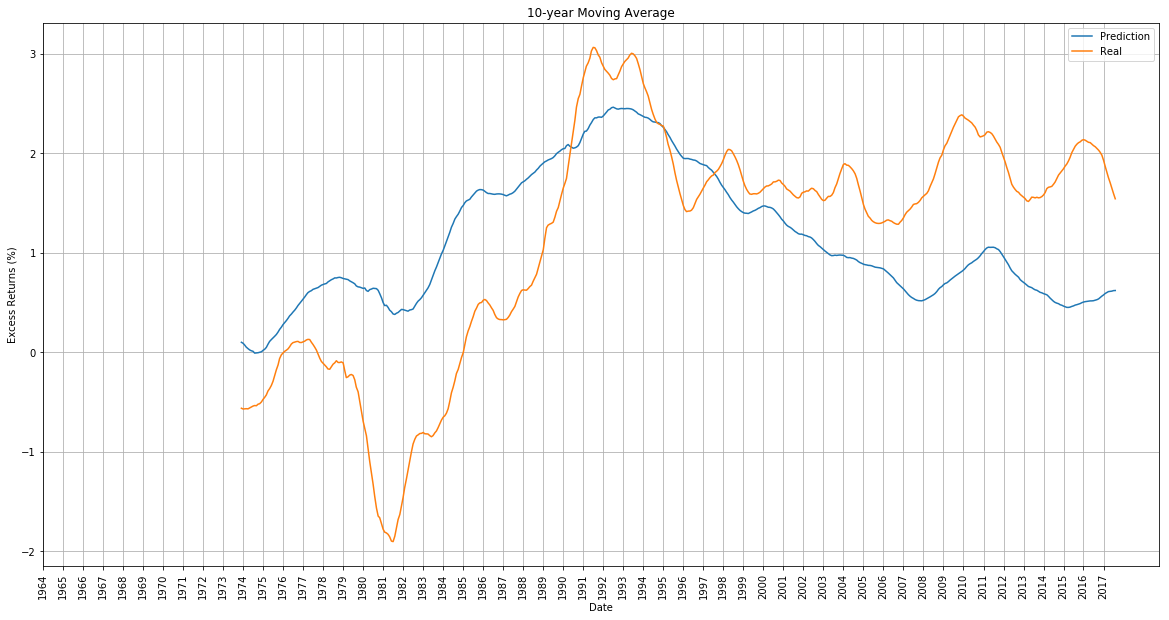

In [349]:
# 5-year moving averages
plt.figure(figsize=(20,10))
plt.plot(pre_bar_ma.rolling(60).mean()*100, label = "Prediction")
plt.plot(rxt_average_ma.rolling(60).mean()*100, label = "Real")
plt.title("5-year Moving Average")
plt.xticks(rxt_average_ma.index[::12], rotation = 90)
plt.xlabel('Date')
plt.ylabel('Excess Returns (%)')
plt.grid()
plt.legend()
plt.show()
# 10-year moving averages
plt.figure(figsize=(20,10))
plt.plot(pre_bar_ma.rolling(120).mean()*100, label = "Prediction")
plt.plot(rxt_average_ma.rolling(120).mean()*100, label = "Real")
plt.title("10-year Moving Average")
plt.xticks(rxt_average_ma.index[::12], rotation = 90)
plt.xlabel('Date')
plt.ylabel('Excess Returns (%)')
plt.grid()
plt.legend()
plt.show()


# Heteroscedaticity Check for 10-year maturities

In [350]:
model = LinearRegression()
R_sq = np.zeros(9)

model.fit(ft_train10,rxt_bar_train10)
gamma = model.coef_
R_sq = model.score(ft_train10,rxt_bar_train10)

aux = pd.DataFrame(np.sum((ft_train10).mul(gamma), axis = 1) + model.intercept_)
#aux.insert(0, 'ones', np.ones(len(aux)))

aux_test = pd.DataFrame(np.sum((ft_test10).mul(gamma), axis = 1) + model.intercept_)
#aux_test.insert(0, 'ones', np.ones(len(aux_test))) 

b = np.zeros(9)
R_sq = np.zeros(9)
rxt_predict = rxt_test10.copy()

for i in range(9):
    model_b = LinearRegression()
    model_b.fit(aux,rxt_train10.iloc[:,i])
    b[i] = model_b.coef_[0]
    rxt_predict.iloc[:,i] = model_b.predict(aux_test)
    R_sq[i] = model_b.score(aux_test,rxt_test10.iloc[:,i])
    visualizer = ResidualsPlot(model_b)
    visualizer.fit(aux, rxt_train10.iloc[:,i])
    visualizer.poof()
plt.figure(figsize=(20,10))
#pre = 0
for i in range(9):
    plt.plot(range(1,11),b[i]*gamma, label = str(i+2))
#    pre = pre + ft_test10.mul(b[i]*gamma)
rxt_predict_bar = np.mean(rxt_predict, axis = 1)
plt.legend()
plt.title('Regression Coefficents (1964-2003)')
plt.show();

NameError: name 'ResidualsPlot' is not defined

In [ ]:
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot

#Instantiate the linear model and visualizer
visualizer = ResidualsPlot(model_b)

visualizer.fit(ft_train5, rxt_bar_train5)  # Fit the training data to the model
#visualizer.score(ft_test5, rxt_bar_test5)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

ridge = Ridge()
visualizer = ResidualsPlot(ridge)

visualizer.fit(ft_train10, rxt_bar_train10)  # Fit the training data to the model
#visualizer.score(ft_test10, rxt_bar_test10)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

In [ ]:
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot

#Instantiate the linear model and visualizer
ridge = Ridge()
visualizer = ResidualsPlot(ridge)

visualizer.fit(ft_train5, rxt_bar_train5)  # Fit the training data to the model
#visualizer.score(ft_test5, rxt_bar_test5)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

ridge = Ridge()
visualizer = ResidualsPlot(ridge)

visualizer.fit(ft_train10, rxt_bar_train10)  # Fit the training data to the model
#visualizer.score(ft_test10, rxt_bar_test10)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

# 1 year prediction by using ROLLING training data set

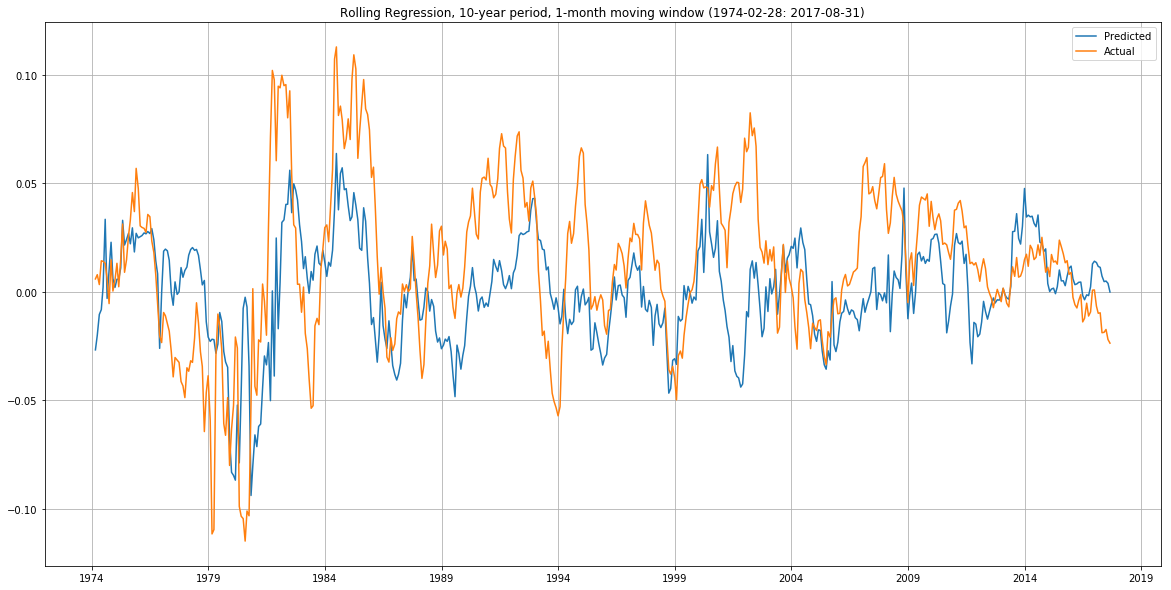

In [362]:
temp = []
# Compute Rolling Regressions
for i, j, z, w in zip(rx['1964-1-1' : '2007-9-1'].index, rx['1974-1-1' : '2017-9-1'].index,
                     rx['1974-2-1' : '2017-9-1'].index, rx['1974-2-1' : '2017-9-1'].index):
    g_roll, b_x_roll, reg_co_roll, pre_roll, pre_bar_roll, rxt_average_roll = (
        simple_model_regressions(i, j, z, w, y, f, rx, 5))
    temp.append(pre_bar_roll)
    
# Transform data    
index = [(temp[i].index) for i in range(len(temp))]
predict_values = [temp[i][0] for i in range(len(temp))]
real_values = rx['1974-2-1':'2017-9-1'].iloc[:,2:6].mean(axis = 1).values
rolling_results = pd.DataFrame({'Predicted': predict_values, 'Real': real_values},
                   index = rx['1974-2-1':'2017-9-1'].index)

# Plot Results
plt.figure(figsize=(20,10))
plt.plot(rolling_results['Predicted'], label="Predicted")
plt.plot(rolling_results['Real'], label="Actual")
plt.legend()
plt.grid()
plt.title('Rolling Regression, 10-year period, 1-month moving window (1974-02-28: 2017-08-31)')
plt.show()

In [364]:
np.corrcoef(rolling_results['Predicted'], rolling_results['Real'])

array([[1.        , 0.46360941],
       [0.46360941, 1.        ]])

In [365]:
import statsmodels.formula.api as sm
result = sm.ols(formula="Real ~ Predicted", data=rolling_results).fit()
print(result.rsquared)

0.21493368453965656


# 1 year prediction by using EXTENDED training data set

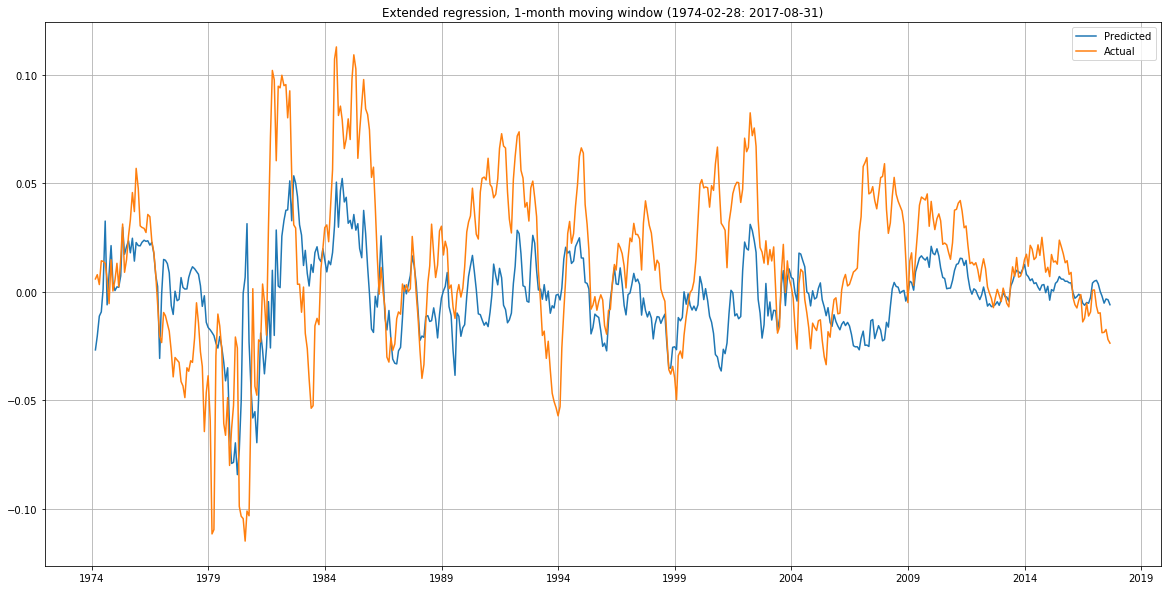

In [450]:
temp = []
# Compute Rolling Regressions
for j, z, w in zip(rx['1974-1-1' : '2017-9-1'].index,rx['1974-2-1' : '2017-9-1'].index,
                      rx['1974-2-1' : '2017-9-1'].index):
    g_ext, b_x_ext, reg_co_ext, pre_ext, pre_bar_ext, rxt_average_ext = (
        simple_model_regressions('1964-1-1', j, z, w, y, f, rx, 5))
    temp.append(pre_bar_ext)
    
# Transform data    
index_extended = [(temp[i].index) for i in range(len(temp))]
predict_values_extended = [temp[i][0] for i in range(len(temp))]
real_values_extended = rx['1974-2-1':'2017-9-1'].iloc[:,2:6].mean(axis = 1).values
extended_results = pd.DataFrame({'Predicted': predict_values_extended, 
                                 'Real': real_values_extended},
                                index = rx['1974-2-1':'2017-9-1'].index)

# Plot Results
plt.figure(figsize=(20,10))
plt.plot(extended_results['Predicted'], label="Predicted")
plt.plot(extended_results['Real'], label="Actual")
plt.legend()
plt.grid()
plt.title('Extended regression, 1-month moving window (1974-02-28: 2017-08-31)')
plt.show()

In [451]:
np.corrcoef(extended_results['Predicted'], extended_results['Real'])

array([[1.        , 0.47269379],
       [0.47269379, 1.        ]])

In [214]:
import statsmodels.formula.api as sm
result = sm.ols(formula="Real ~ Predicted", data=extended_results).fit()
print(result.rsquared)

0.2234394209996926


# Functions for the multiple lags regression

In [478]:
# Function to run the regressions
def simple_model_regressions_lags (start_train, end_train, start_test, end_test, 
                              returns_data, forwards_data, excess_ret_data, maturity, lags):
    
    # Determine Date periods
    idx = ((returns_data.index >= pd.to_datetime(start_train)) &
           (returns_data.index <= pd.to_datetime(end_test)))
    idx_train = ((returns_data.index >= pd.to_datetime(start_train)) & 
                  (returns_data.index <= pd.to_datetime(end_train)))
    idx_test = ((returns_data.index >= pd.to_datetime(start_test)) &
                 (returns_data.index <= pd.to_datetime(end_test)))

    # Select appropiate data and divide it into train set and test set
    yt = returns_data[idx].iloc[:,1:(maturity+1)]
    ft = forwards_data[idx].iloc[:,1:(maturity+1)]
    rxt = (excess_ret_data[idx].iloc[:,2:(maturity+1)])[lags:]
    rxt_bar = rxt.mean(axis = 1)

    # Select 5 year train data
    yt_train = returns_data[idx_train].iloc[:,1:(maturity+1)]
    ft_train = forwards_data[idx_train].iloc[:,1:(maturity+1)]
    rxt_train = (excess_ret_data[idx_train].iloc[:,2:(maturity+1)])[lags:]
    rxt_bar_train = rxt_train.mean(axis = 1)

    # Select 5 year test data
    yt_test = returns_data[idx_test].iloc[:,1:(maturity+1)]
    ft_test = forwards_data[idx_test].iloc[:,1:(maturity+1)]
    rxt_test = (excess_ret_data[idx_test].iloc[:,2:(maturity+1)])[lags:]
    rxt_bar_test = rxt_test.mean(axis = 1)
    
    a = np.zeros(lags + 1)
    for i in range (lags+1):
        a[i] = 0.3
        
    alpha_error = 1
    while (alpha_error > 0.0001):
        temp = a[0]*ft_train
        for i in range (1, lags+1):
            temp = temp + a[i]*ft_train.shift(i)
        temp = temp.dropna()

        # First Regression. Fix alpha, compute gamma coefficients
        model = LinearRegression()
        R_sq = np.zeros((maturity-1))

        model.fit(temp,rxt_bar_train)
        gamma = model.coef_
        R_sq_x = model.score(temp,rxt_bar_train)

        # Second Regression. Fix Gamma, compute alpha coefficients
        temp2 = pd.DataFrame()
        for i in range(lags + 1):
            temp2[str(i)] = np.sum(ft_train.shift(i).iloc[lags:].mul(gamma), axis = 1) + model.intercept_

        model_alpha = LinearRegression()
        model_alpha.fit(temp2, rxt_bar_train)
        alpha_coefs = model_alpha.coef_
        alpha_error = np.sum((a-alpha_coefs)**2)
        a = alpha_coefs
    
    # Third Regression. Compute b
    temp3 = a[0]*ft_train
    for i in range (1, lags+1):
        temp3 = temp3 + a[i]*ft_train.shift(i)
    temp3 = temp3.dropna()
    aux = pd.DataFrame(np.sum(temp3.mul(gamma), axis = 1) + model_alpha.intercept_)
    
    temp4 = a[0]*ft_test
    for i in range (1, lags+1):
        temp4 = temp4 + a[i]*ft_test.shift(i)
    temp4 = temp4.dropna()
    aux_test = pd.DataFrame(np.sum(temp4.mul(gamma), axis = 1) + model_alpha.intercept_)

    models = []
    b = np.zeros((maturity-1))
    reg_coefs = np.zeros([maturity,maturity-1])
    R_sq = np.zeros((maturity-1))
    rxt_predict = rxt_test.copy()
    

    for i in range((maturity-1)):
        model_b = LinearRegression()
        model_b.fit(aux,rxt_train.iloc[:,i])
        b[i] = model_b.coef_[0]
        reg_coefs[:,i] = b[i]*gamma
        rxt_predict.iloc[:,i] = model_b.predict(aux_test)
        R_sq[i] = model_b.score(aux_test,rxt_test.iloc[:,i])
        models.append(model_b)
    rxt_predict_bar = np.mean(rxt_predict, axis = 1)

    return gamma, b, reg_coefs, rxt_predict, rxt_predict_bar, rxt_bar, R_sq_x

In [479]:
g_lg, b_lg, coef_lg, pre_lg, pre_bar_lg, rxt_bar_lg, r_sq_lg = (
    simple_model_regressions_lags ('1964-1-1', '2017-1-1', '1964-1-1', '2017-1-1', y,
                              f, rx, 5, 3))

# Rolling Regression with 3-month lag

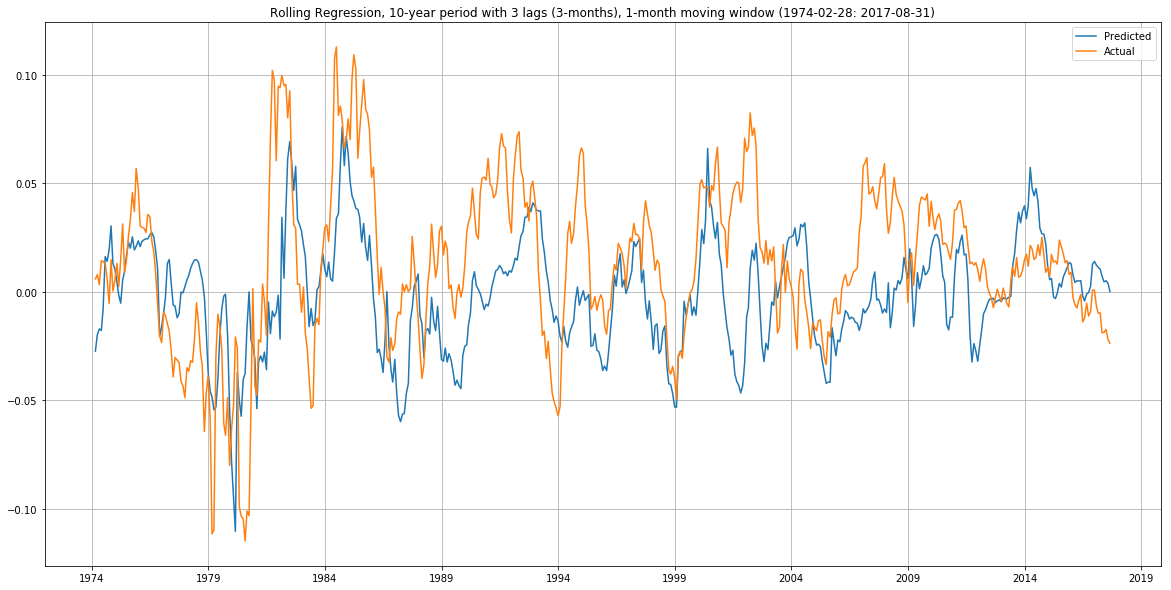

In [486]:
temp_lag = []
# Compute Rolling Regressions
for i, j, z, w in zip(rx['1964-1-1' : '2007-9-1'].index, rx['1974-1-1' : '2017-9-1'].index,
                     rx['1973-11-1' : '2017-9-1'].index, rx['1974-2-1' : '2017-9-1'].index):
    g_roll, b_x_roll, reg_co_roll, pre_roll, pre_bar_roll, rxt_average_roll, R_sq= (
        simple_model_regressions_lags(i, j, z, w, y, f, rx, 5, 3))
    temp_lag.append(pre_bar_roll)

#Transform
index = [(temp_lag[i].index) for i in range(len(temp_lag))]
predict_values = [temp_lag[i][0] for i in range(len(temp_lag))]
real_values = rx['1974-2-1':'2017-9-1'].iloc[:,2:6].mean(axis = 1).values
rolling_results_lag = pd.DataFrame({'Predicted': predict_values, 'Real': real_values},
                   index = rx['1974-2-1':'2017-9-1'].index)

# Plot Results
plt.figure(figsize=(20,10))
plt.plot(rolling_results_lag['Predicted'], label="Predicted")
plt.plot(rolling_results_lag['Real'], label="Actual")
plt.legend()
plt.grid()
plt.title('Rolling Regression, 10-year period with 3 lags (3-months), 1-month moving window (1974-02-28: 2017-08-31)')
plt.show()

In [487]:
result_lag = sm.ols(formula="Real ~ Predicted", data=rolling_results_lag).fit()
print(result_lag.rsquared)
np.corrcoef(rolling_results_lag['Predicted'], rolling_results_lag['Real'])

0.2378074743743559


array([[1.        , 0.48765508],
       [0.48765508, 1.        ]])

# Extended Regression with 3-month lag

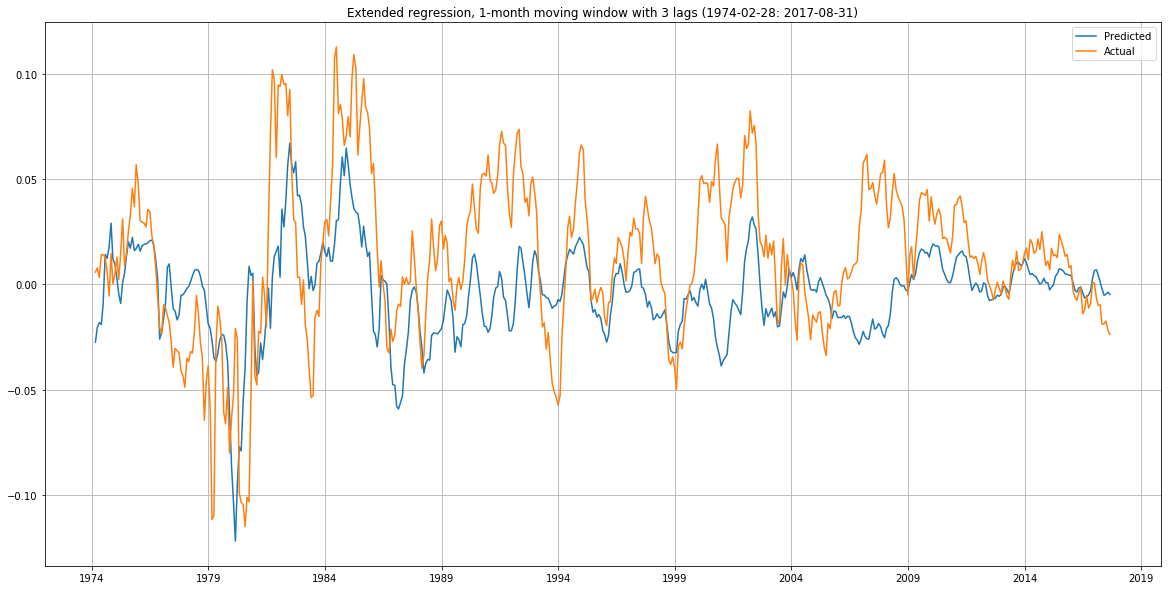

In [492]:
temp = []
# Compute Rolling Regressions
for j, z, w in zip(rx['1974-1-1' : '2017-9-1'].index,rx['1973-11-1' : '2017-9-1'].index, 
                   rx['1974-2-1' : '2017-9-1'].index):
    g_ext, b_x_ext, reg_co_ext, pre_ext, pre_bar_ext, rxt_average_ext, R_sq_lag = (
        simple_model_regressions_lags('1964-1-1', j, z, w, y, f, rx, 5, 3))
    temp.append(pre_bar_ext)
    
# Transform data    
index_extended = [(temp[i].index) for i in range(len(temp))]
predict_values_extended = [temp[i][0] for i in range(len(temp))]
real_values_extended = rx['1974-2-1':'2017-9-1'].iloc[:,2:6].mean(axis = 1).values
extended_results_lag = pd.DataFrame({'Predicted': predict_values_extended, 
                                 'Real': real_values_extended},
                                index = rx['1974-2-1':'2017-9-1'].index)

# Plot Results
plt.figure(figsize=(20,10))
plt.plot(extended_results_lag['Predicted'], label="Predicted")
plt.plot(extended_results_lag['Real'], label="Actual")
plt.legend()
plt.grid()
plt.title('Extended regression, 1-month moving window with 3 lags (1974-02-28: 2017-08-31)')
plt.show()

In [493]:
result_lag = sm.ols(formula="Real ~ Predicted", data=extended_results_lag).fit()
print(result_lag.rsquared)
np.corrcoef(extended_results_lag['Predicted'], extended_results_lag['Real'])

0.24930683947296772


array([[1.        , 0.49930636],
       [0.49930636, 1.        ]])